In [1]:
# ============================================
# BLOCCO 0 - Import e configurazione
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

plt.style.use("default")
sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"

In [2]:
# ============================================
# BLOCCO 1 - ETL & Preprocessing
# ============================================
print("=== 1. ETL & PREPROCESSING ===")

# Caricamento
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
df_raw = pd.concat([train, test], ignore_index=True)
print("Shape originale:", df_raw.shape)

# Copia di lavoro completa (serve per profilazione cluster)
df = df_raw.copy()

# Drop colonne inutili
cols_to_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
if "id" in df.columns:
    cols_to_drop.append("id")
if cols_to_drop:
    print("Drop colonne:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# Identificazione colonne target utili per analisi successive
sat_col = next((c for c in df.columns if "satisf" in c.lower()), None)
class_col = "Class" if "Class" in df.columns else None
print("Colonna soddisfazione:", sat_col)
print("Colonna classe:", class_col)

# Escludo la soddisfazione dalle feature usate per PCA/t-SNE/clustering
if sat_col is not None:
    df_features = df.drop(columns=[sat_col])
else:
    df_features = df.copy()

# Numeriche / categoriche sulle sole feature
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df_features.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Gestione NA
df_features[num_cols] = df_features[num_cols].fillna(df_features[num_cols].median())
for c in cat_cols:
    df_features[c] = df_features[c].fillna(df_features[c].mode().iloc[0])

# One-hot encoding
df_encoded = pd.get_dummies(df_features, columns=cat_cols, drop_first=True)
print("Shape dopo dummies:", df_encoded.shape)

# Standardizzazione per PCA / t-SNE / clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.values)
print("X_scaled shape:", X_scaled.shape)

print("\n=== 1 BIS. CHECK QUALITÀ DATI ===")

# Duplicati
dup = df.duplicated().sum()
print("Duplicati presenti:", dup)

# Valori mancanti (dopo imputazione)
na_tot = df_features.isna().sum().sum()
print("NA totali dopo imputazione:", na_tot)

# Salvo le colonne numeriche originali (utile per profiling cluster)
num_cols_original = num_cols.copy()
cat_cols_original = cat_cols.copy()
print("Colonne numeriche originali:", len(num_cols_original))
print("Colonne categoriche originali:", len(cat_cols_original))

# Mini riepilogo
print("\nRiepilogo:")
print("Righe:", df_features.shape[0])
print("Feature dopo encoding:", df_encoded.shape[1])
print("Colonne numeriche:", num_cols_original[:])
print("Colonne categoriche:", cat_cols_original[:5])

=== 1. ETL & PREPROCESSING ===
Shape originale: (129880, 25)
Drop colonne: ['Unnamed: 0', 'id']
Colonna soddisfazione: satisfaction
Colonna classe: Class
Shape dopo dummies: (129880, 23)
X_scaled shape: (129880, 23)

=== 1 BIS. CHECK QUALITÀ DATI ===
Duplicati presenti: 0
NA totali dopo imputazione: 0
Colonne numeriche originali: 18
Colonne categoriche originali: 4

Riepilogo:
Righe: 129880
Feature dopo encoding: 23
Colonne numeriche: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Colonne categoriche: ['Gender', 'Customer Type', 'Type of Travel', 'Class']


=== 2. Varianza per feature (spazio originale) ===
                                        Variance      StdDev
Flight Distance                    994911.444525  997.452477
Arrival Delay in Minutes             1475.816156   38.416353
Departure Delay in Minutes           1449.410651   38.071126
Age                                   228.595045   15.119360
Departure/Arrival time convenient       2.330940    1.526741
Ease of Online booking                  1.964874    1.401740
Online boarding                         1.824441    1.350719
Inflight entertainment                  1.779687    1.334049
Food and drink                          1.768722    1.329933
Inflight wifi service                   1.767145    1.329340
Seat comfort                            1.740523    1.319289
Leg room service                        1.732519    1.316252
Cleanliness                             1.725761    1.313682
On-board service                        1.656625    1.287099
Gate location                     

/tmp/ipython-input-2427950388.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


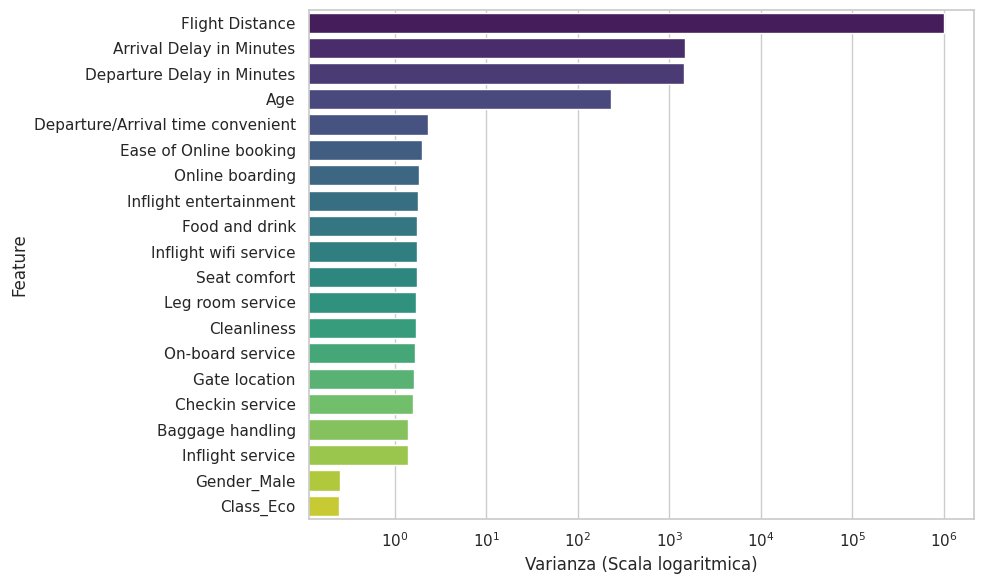

In [3]:
# ============================================
# BLOCCO 2 - Varianza per feature
# (prima della standardizzazione)
# ============================================
print("=== 2. Varianza per feature (spazio originale) ===")

# Calcolo varianza e deviazione standard
feature_variance = df_encoded.var().sort_values(ascending=False)
feature_std = df_encoded.std().sort_values(ascending=False)

var_df = pd.DataFrame({
    "Variance": feature_variance,
    "StdDev": feature_std
})

print(var_df)

# Plot top 20 feature per varianza (scala logaritmica)
plt.figure(figsize=(10,6))
sns.barplot(
    x=var_df.iloc[:20]["Variance"],
    y=var_df.iloc[:20].index,
    palette="viridis"
)
plt.xscale("log")
plt.xlabel("Varianza (Scala logaritmica)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

=== 3. PCA ===


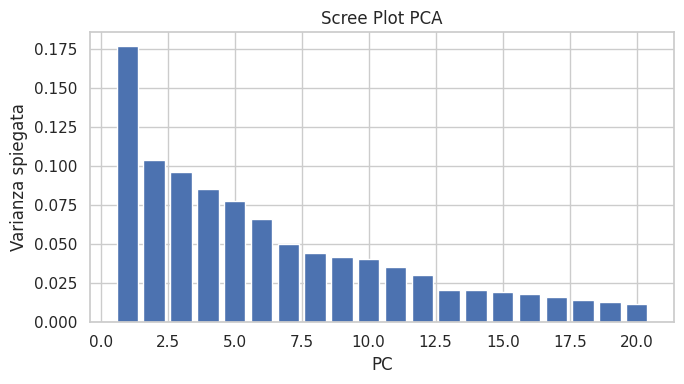

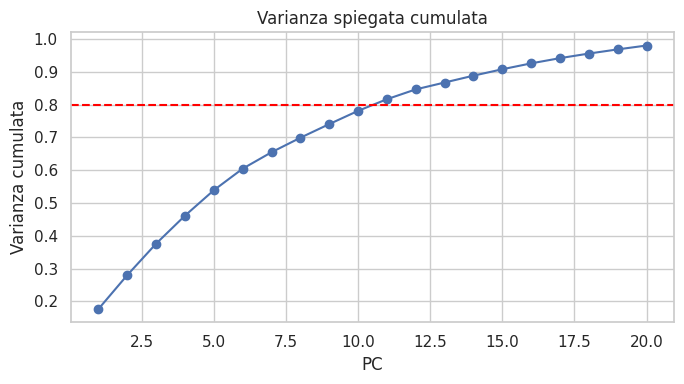

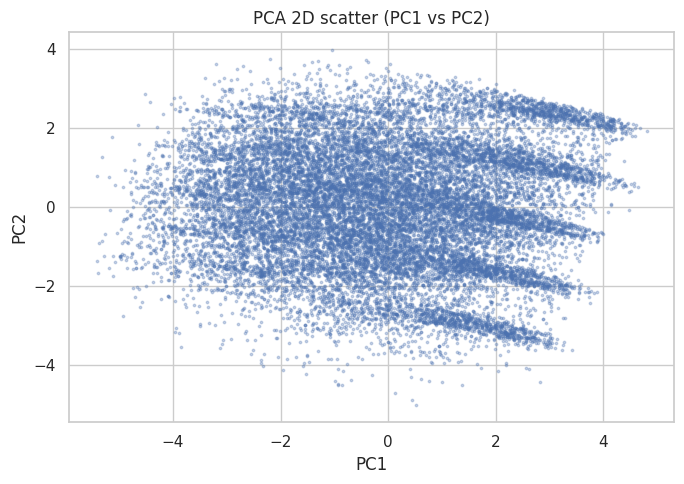

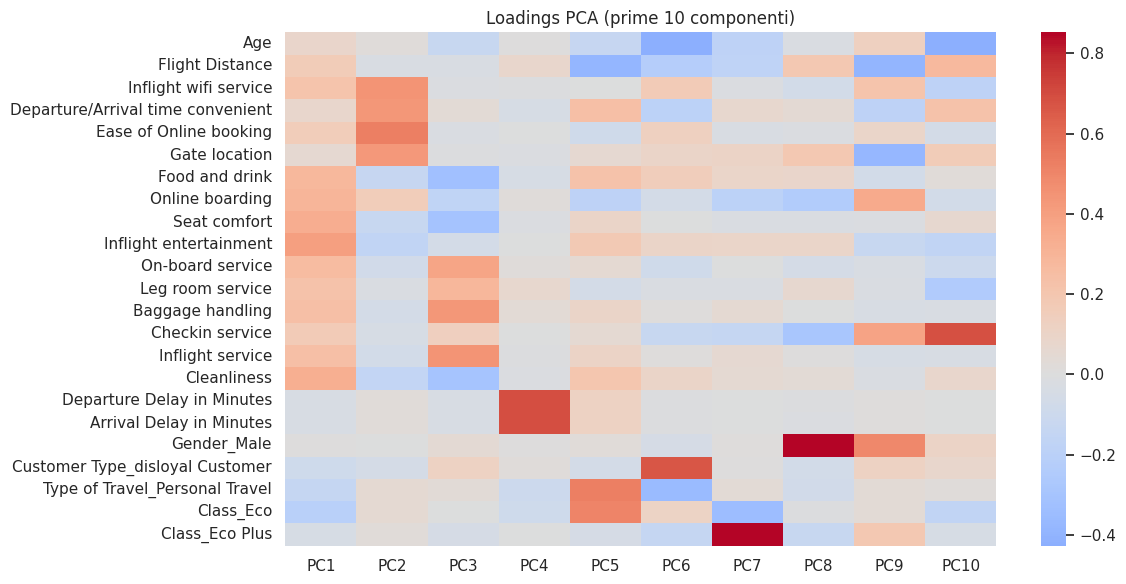

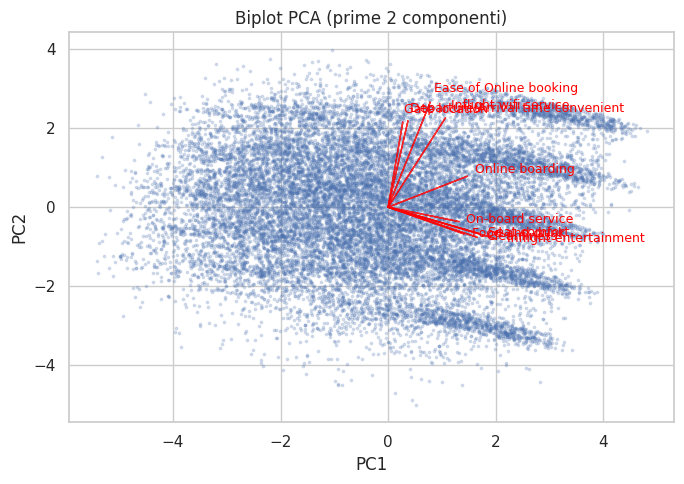

=== Importanza totale delle feature nei primi 10 PC ===
                              Feature  Importance
13                    Checkin service    2.037531
1                     Flight Distance    1.943901
7                     Online boarding    1.736934
18                        Gender_Male    1.594491
0                                 Age    1.554453
3   Departure/Arrival time convenient    1.544767
21                          Class_Eco    1.519090
22                     Class_Eco Plus    1.512343
5                       Gate location    1.500269
6                      Food and drink    1.420073
20     Type of Travel_Personal Travel    1.383060
9              Inflight entertainment    1.377553
2               Inflight wifi service    1.350122
15                        Cleanliness    1.297576
19    Customer Type_disloyal Customer    1.267664
4              Ease of Online booking    1.119114
10                   On-board service    1.049003
11                   Leg room service    1.0

/tmp/ipython-input-3368189139.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


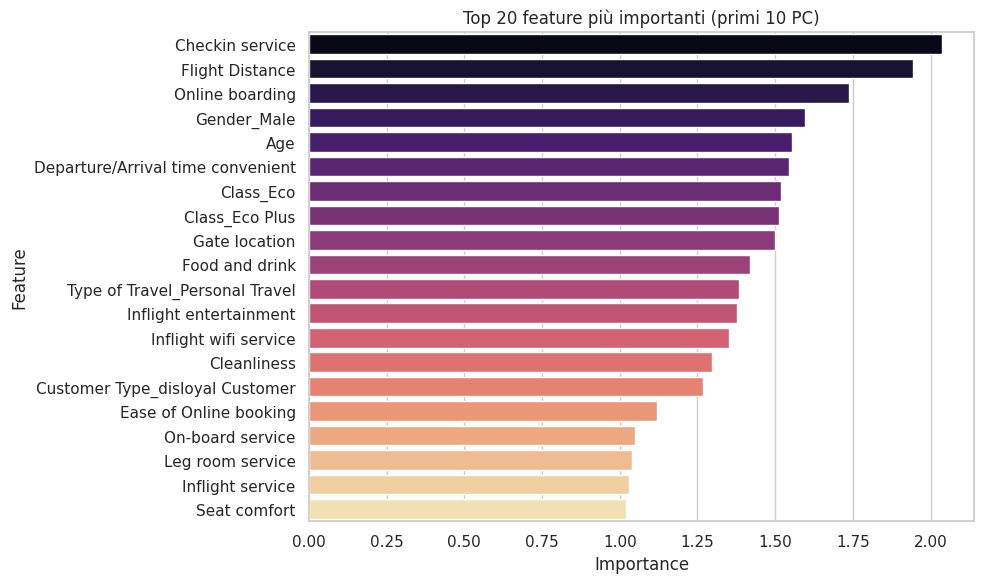

In [4]:
# ============================================
# BLOCCO 3 - PCA
# ============================================
print("=== 3. PCA ===")

N_PCS = min(20, X_scaled.shape[1])
pca = PCA(n_components=N_PCS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_
cum_expl_var = expl_var.cumsum()

# Scree plot
plt.figure(figsize=(7,4))
plt.bar(range(1, N_PCS+1), expl_var)
plt.title("Scree Plot PCA")
plt.xlabel("PC")
plt.ylabel("Varianza spiegata")
plt.tight_layout()
plt.show()

# Varianza cumulata
plt.figure(figsize=(7,4))
plt.plot(range(1, N_PCS+1), cum_expl_var, marker='o')
plt.axhline(0.80, linestyle='--', color='red')
plt.title("Varianza spiegata cumulata")
plt.xlabel("PC")
plt.ylabel("Varianza cumulata")
plt.tight_layout()
plt.show()

# Scatter PC1 vs PC2 (subset riproducibile)
rng = np.random.RandomState(RANDOM_STATE)
idx = rng.choice(len(X_pca), size=min(20000, len(X_pca)), replace=False)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[idx,0], X_pca[idx,1], s=3, alpha=0.3)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA 2D scatter (PC1 vs PC2)")
plt.tight_layout()
plt.show()

# Loadings (completo)
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_encoded.columns,
    columns=[f"PC{i+1}" for i in range(N_PCS)]
)

# Heatmap loadings (prime 10 PC per leggibilità)
plt.figure(figsize=(12,6))
sns.heatmap(loadings.iloc[:, :10], cmap='coolwarm', center=0)
plt.title("Loadings PCA (prime 10 componenti)")
plt.tight_layout()
plt.show()

# Biplot (PC1 vs PC2, 10 variabili più importanti)
importance = loadings[["PC1", "PC2"]].abs().sum(axis=1)
top_vars = importance.sort_values(ascending=False).head(10).index
top_load = loadings.loc[top_vars, ["PC1", "PC2"]].values

plt.figure(figsize=(7,5))
plt.scatter(X_pca[idx,0], X_pca[idx,1], s=3, alpha=0.2)
for i, (x, y) in enumerate(top_load):
    plt.arrow(0, 0, x*5, y*5, color='red', alpha=0.8)
    plt.text(x*5*1.1, y*5*1.1, top_vars[i], fontsize=9, color='red')
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Biplot PCA (prime 2 componenti)")
plt.tight_layout()
plt.show()

# Importanza totale delle feature nei primi 10 PC
print("=== Importanza totale delle feature nei primi 10 PC ===")
n_pc = 10
abs_load = np.abs(pca.components_[:n_pc])
feat_importance = abs_load.sum(axis=0)

feat_imp_df = pd.DataFrame({
    "Feature": df_encoded.columns,
    "Importance": feat_importance
}).sort_values("Importance", ascending=False)

print(feat_imp_df.head(20))

plt.figure(figsize=(10,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp_df.head(20),
    palette="magma"
)
plt.title("Top 20 feature più importanti (primi 10 PC)")
plt.tight_layout()
plt.show()

=== 4. t-SNE ===


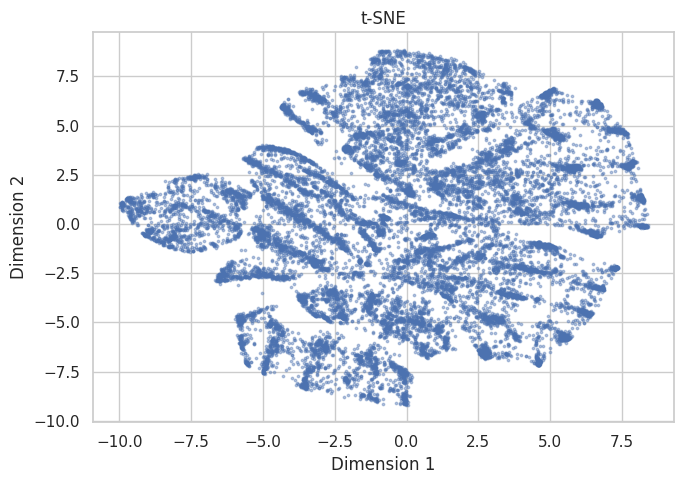

X_tsne shape: (20000, 2)


In [8]:
# ============================================
# BLOCCO 4 - t-SNE (2D) SU PCA (aggiornato)
# ============================================
print("=== 4. t-SNE ===")

TSNE_SAMPLES = min(20000, len(X_scaled))

# campionamento riproducibile
rng = np.random.RandomState(RANDOM_STATE)
idx_tsne = rng.choice(len(X_scaled), TSNE_SAMPLES, replace=False)

N_PC_TSNE = 10
X_for_tsne = X_pca[idx_tsne, :N_PC_TSNE]

df_tsne_raw = df_raw.iloc[idx_tsne].reset_index(drop=True)
df_tsne_encoded = df_encoded.iloc[idx_tsne].reset_index(drop=True)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=300,
    init="pca",
    random_state=RANDOM_STATE
)

X_tsne = tsne.fit_transform(X_for_tsne)

plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=3, alpha=0.4)
plt.title(f"t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()

print("X_tsne shape:", X_tsne.shape)

=== 5. K-Means su t-SNE ===


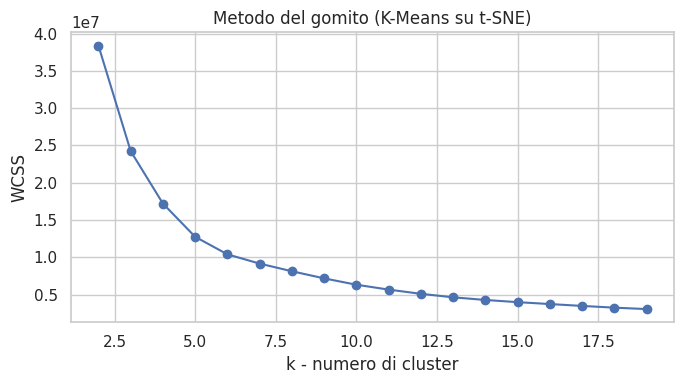

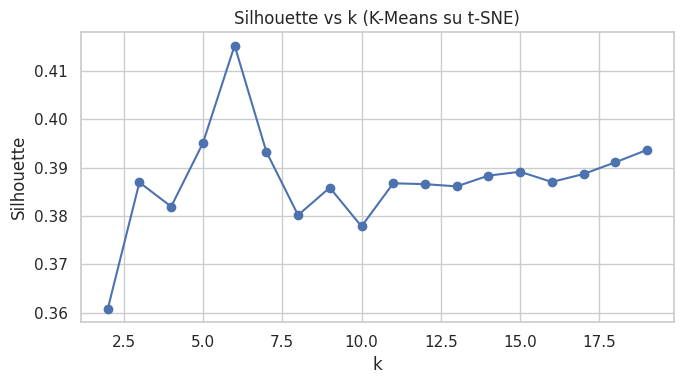

     k         WCSS  Silhouette
0    2  38396288.00    0.360778
1    3  24253282.00    0.386991
2    4  17226272.00    0.381976
3    5  12767280.00    0.395099
4    6  10417548.00    0.415304
5    7   9177285.00    0.393339
6    8   8151652.00    0.380215
7    9   7198248.00    0.385906
8   10   6345936.50    0.377889
9   11   5694554.50    0.386801
10  12   5128302.00    0.386626
11  13   4660106.00    0.386162
12  14   4303419.50    0.388386
13  15   4011830.00    0.389187
14  16   3756468.00    0.387076
15  17   3505018.00    0.388719
16  18   3274441.25    0.391142
17  19   3084376.50    0.393706

Silhouette K-Means (spazio t-SNE): 0.387

Numero di osservazioni per cluster:
0    7381
1    5380
2    7239
Name: count, dtype: int64


/tmp/ipython-input-2954440857.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K_OPT)


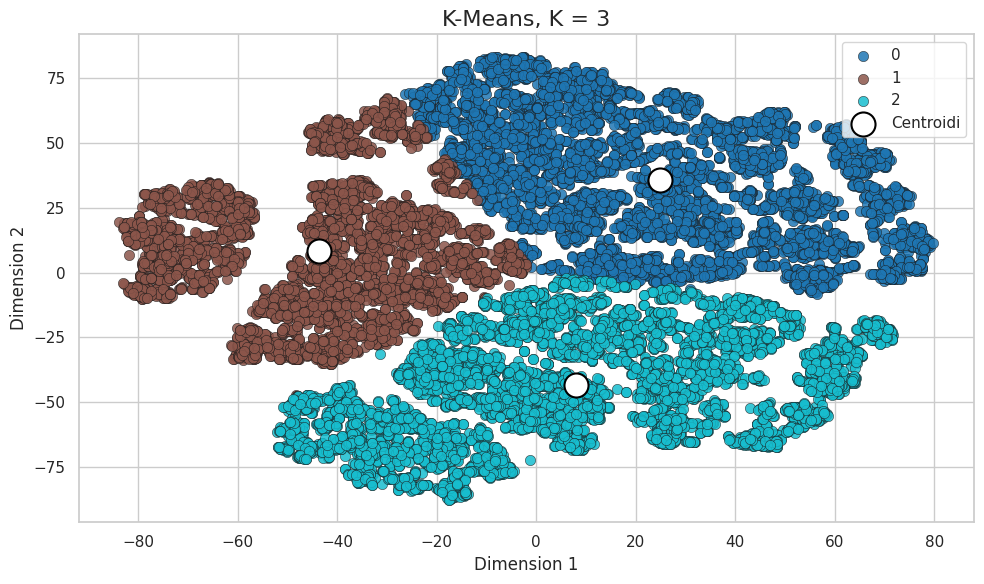

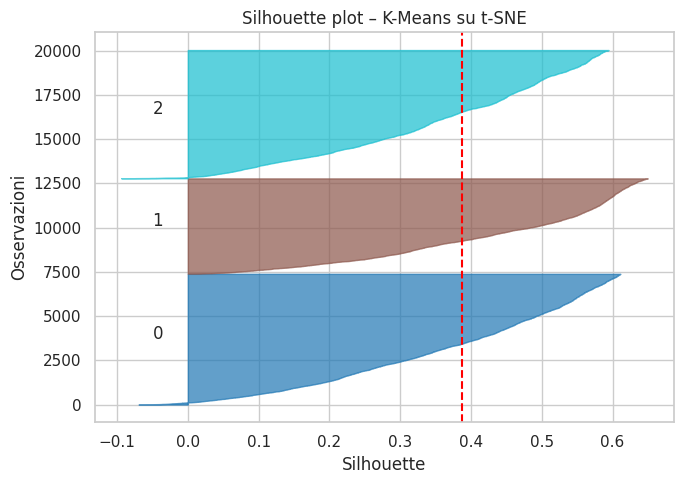

In [7]:
# ============================================
# BLOCCO 5 - K-Means su t-SNE (aggiornato)
# ============================================
print("=== 5. K-Means su t-SNE ===")

K_range = range(2, 20)
wcss = []
sils = []

# -------------------------------------------------
# 5.1 Metodo del gomito + silhouette vs K
# -------------------------------------------------
for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels_tmp = km.fit_predict(X_tsne)
    wcss.append(km.inertia_)
    sils.append(silhouette_score(X_tsne, labels_tmp))

plt.figure(figsize=(7,4))
plt.plot(list(K_range), wcss, marker='o')
plt.title("Metodo del gomito (K-Means su t-SNE)")
plt.xlabel("k - numero di cluster")
plt.ylabel("WCSS")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(list(K_range), sils, marker='o')
plt.title("Silhouette vs k (K-Means su t-SNE)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

print(pd.DataFrame({
    "k": list(K_range),
    "WCSS": wcss,
    "Silhouette": sils
}))

# -------------------------------------------------
# 5.2 Clustering con K ottimale
# -------------------------------------------------
K_OPT = 3
kmeans = KMeans(
    n_clusters=K_OPT,
    n_init=20,
    random_state=RANDOM_STATE
)

labels_km = kmeans.fit_predict(X_tsne)

sil_km = silhouette_score(X_tsne, labels_km)
print("\nSilhouette K-Means (spazio t-SNE):", round(sil_km, 3))

# numerosità cluster
counts = pd.Series(labels_km).value_counts().sort_index()
print("\nNumero di osservazioni per cluster:")
print(counts)

# -------------------------------------------------
# 5.3 Scatter "stile relazione" CON centroidi
# -------------------------------------------------
plt.figure(figsize=(10,6))

cmap = plt.cm.get_cmap("tab10", K_OPT)

for c in range(K_OPT):
    mask_c = labels_km == c
    plt.scatter(
        X_tsne[mask_c, 0],
        X_tsne[mask_c, 1],
        s=55,
        alpha=0.85,
        c=[cmap(c)],
        edgecolors="k",
        linewidths=0.4,
        label=str(c)
    )

# centroidi
plt.scatter(
    kmeans.cluster_centers_[:,0],
    kmeans.cluster_centers_[:,1],
    c="white",
    s=300,
    edgecolors="black",
    linewidths=1.5,
    marker="o",
    label="Centroidi"
)

plt.title(f"K-Means, K = {K_OPT}", fontsize=16)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 5.4 Silhouette plot per cluster
# -------------------------------------------------
sample_sil = silhouette_samples(X_tsne, labels_km)

plt.figure(figsize=(7,5))
y_lower = 10

for i in range(K_OPT):
    ith = sample_sil[labels_km == i]
    ith.sort()
    size = ith.shape[0]
    y_upper = y_lower + size

    color = cmap(i)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith,
        color=color,
        alpha=0.7
    )
    plt.text(-0.05, y_lower + size * 0.5, str(i))
    y_lower = y_upper + 10

plt.axvline(sil_km, color='red', linestyle='--')
plt.title("Silhouette plot – K-Means su t-SNE")
plt.xlabel("Silhouette")
plt.ylabel("Osservazioni")
plt.tight_layout()
plt.show()

=== 6. Profilazione cluster K-Means (k=3) ===

Numero di osservazioni per cluster K-Means:
Cluster 0: 7381 osservazioni
Cluster 1: 5380 osservazioni
Cluster 2: 7239 osservazioni


/tmp/ipython-input-3607783195.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


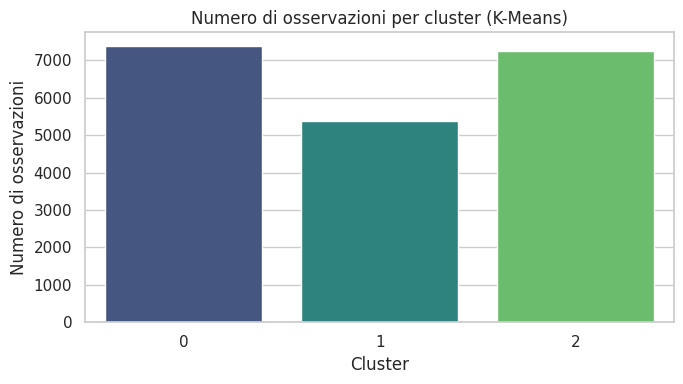

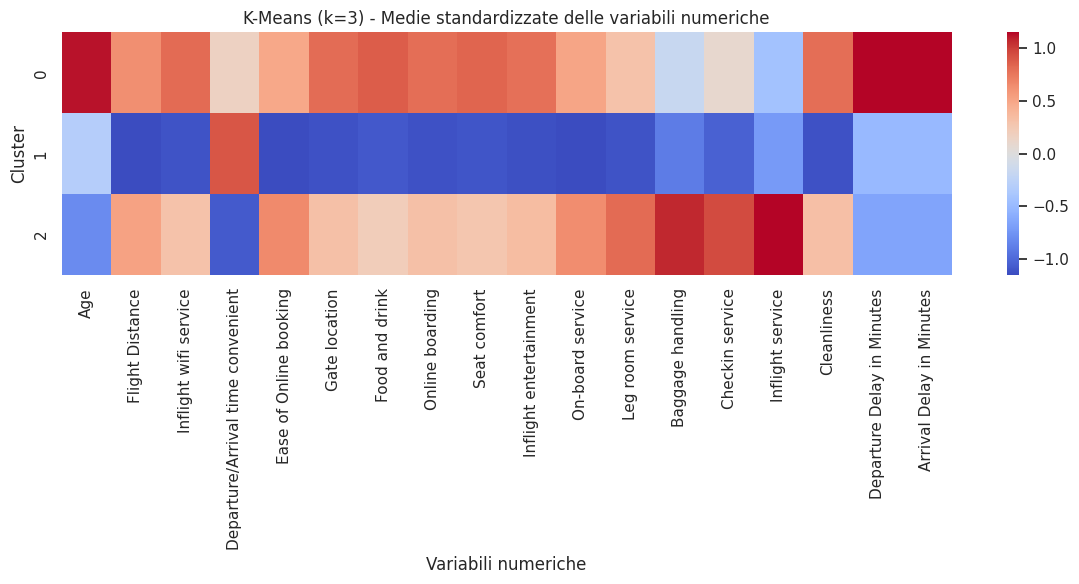

Distribuzione soddisfazione per cluster K-Means (%):
satisfaction  neutral or dissatisfied  satisfied
cluster_km                                      
0                                48.0       52.0
1                                81.3       18.7
2                                47.5       52.5


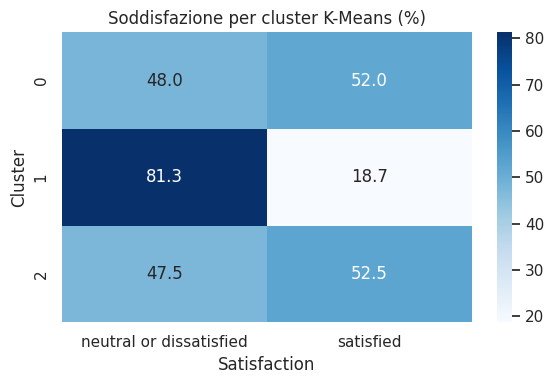

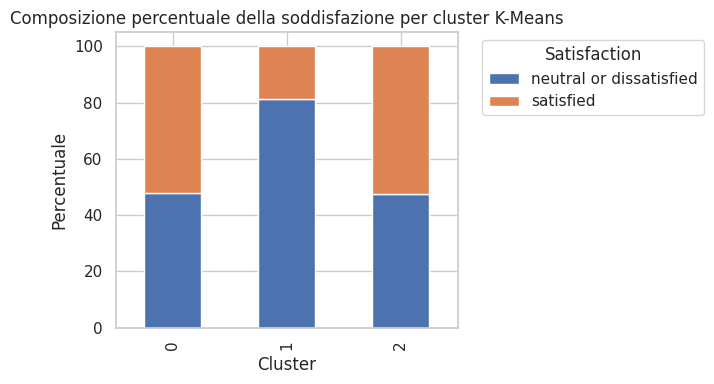

Distribuzione classe di viaggio per cluster K-Means (%):
Class       Business   Eco  Eco Plus
cluster_km                          
0               57.4  42.4       0.1
1                3.8  69.7      26.5
2               72.0  28.0       0.0


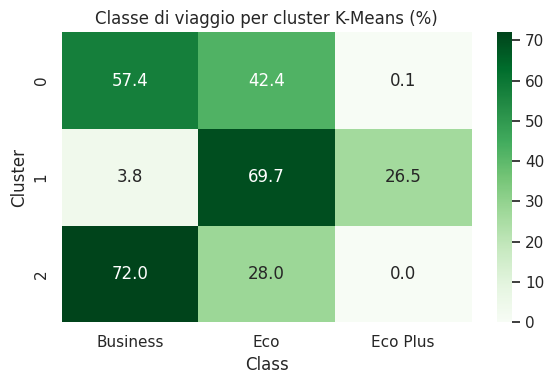

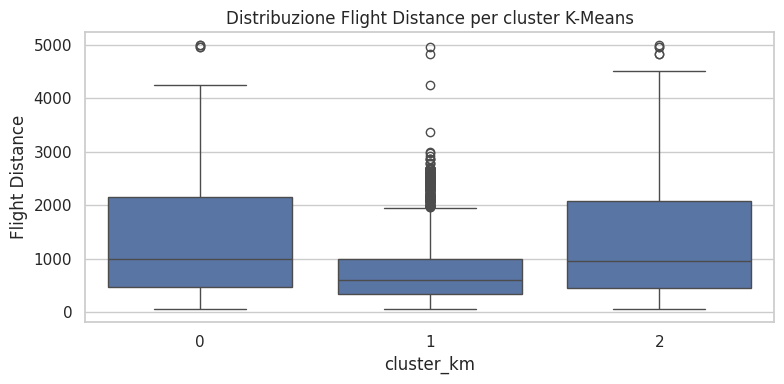


=== Top / bottom variabili per cluster K-Means ===

=== Cluster K-Means 0 ===
TOP 5 variabili (sopra media globale):
Arrival Delay in Minutes      1.15
Departure Delay in Minutes    1.15
Age                           1.12
Food and drink                0.88
Seat comfort                  0.84
Name: 0, dtype: float64
BOTTOM 5 variabili (sotto media globale):
Inflight service                    -0.43
Baggage handling                    -0.18
Checkin service                      0.09
Departure/Arrival time convenient    0.16
Leg room service                     0.30
Name: 0, dtype: float64

=== Cluster K-Means 1 ===
TOP 5 variabili (sopra media globale):
Departure/Arrival time convenient    0.91
Age                                 -0.31
Departure Delay in Minutes          -0.50
Arrival Delay in Minutes            -0.50
Inflight service                    -0.71
Name: 1, dtype: float64
BOTTOM 5 variabili (sotto media globale):
Flight Distance          -1.15
On-board service         -1.15
Eas

/tmp/ipython-input-3607783195.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sat_mean.index, y=sat_mean.values, palette="coolwarm")


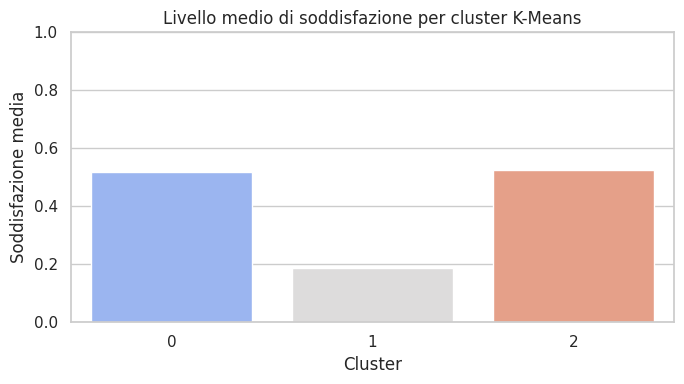

In [ ]:
# ============================================
# BLOCCO 6 - Profilazione cluster K-Means
# ============================================
print("=== 6. Profilazione cluster K-Means (k=3) ===")

df_km = df_tsne_encoded.copy()
df_km["cluster_km"] = labels_km

# Numero di osservazioni per cluster
cluster_counts = df_km["cluster_km"].value_counts().sort_index()
print("\nNumero di osservazioni per cluster K-Means:")
for c, n in cluster_counts.items():
    print(f"Cluster {c}: {n} osservazioni")

plt.figure(figsize=(7,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Numero di osservazioni per cluster (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Numero di osservazioni")
plt.tight_layout()
plt.show()

num_cols_encoded = [c for c in df_encoded.columns if c in num_cols]

cluster_means_km = df_km.groupby("cluster_km")[num_cols_encoded].mean()
cluster_means_km_std = (cluster_means_km - cluster_means_km.mean()) / cluster_means_km.std()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means_km_std, cmap="coolwarm", center=0)
plt.title("K-Means (k=3) - Medie standardizzate delle variabili numeriche")
plt.xlabel("Variabili numeriche")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

# Distribuzione soddisfazione per cluster
if sat_col is not None:
    df_km_sat = df_tsne_raw[[sat_col]].copy()
    df_km_sat["cluster_km"] = labels_km

    sat_ct = pd.crosstab(df_km_sat["cluster_km"], df_km_sat[sat_col],
                         normalize="index") * 100
    print("Distribuzione soddisfazione per cluster K-Means (%):")
    print(sat_ct.round(1))

    plt.figure(figsize=(6,4))
    sns.heatmap(sat_ct.round(1), annot=True, fmt=".1f", cmap="Blues")
    plt.title("Soddisfazione per cluster K-Means (%)")
    plt.ylabel("Cluster")
    plt.xlabel("Satisfaction")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    ax = plt.gca()
    sat_ct.plot(kind="bar", stacked=True, ax=ax)
    plt.title("Composizione percentuale della soddisfazione per cluster K-Means")
    plt.xlabel("Cluster")
    plt.ylabel("Percentuale")
    plt.legend(title="Satisfaction", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Distribuzione classe di viaggio per cluster
if class_col is not None:
    df_km_class = df_tsne_raw[[class_col]].copy()
    df_km_class["cluster_km"] = labels_km

    class_ct = pd.crosstab(df_km_class["cluster_km"], df_km_class[class_col],
                           normalize="index") * 100
    print("Distribuzione classe di viaggio per cluster K-Means (%):")
    print(class_ct.round(1))

    plt.figure(figsize=(6,4))
    sns.heatmap(class_ct.round(1), annot=True, fmt=".1f", cmap="Greens")
    plt.title("Classe di viaggio per cluster K-Means (%)")
    plt.ylabel("Cluster")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

# Boxplot Flight Distance per cluster
if "Flight Distance" in num_cols:
    df_km_fd = df_tsne_raw[["Flight Distance"]].copy()
    df_km_fd["cluster_km"] = labels_km

    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_km_fd, x="cluster_km", y="Flight Distance")
    plt.title("Distribuzione Flight Distance per cluster K-Means")
    plt.tight_layout()
    plt.show()

# --- Top / bottom variabili per cluster K-Means ---
print("\n=== Top / bottom variabili per cluster K-Means ===")
for c in range(K_OPT):   # assicurati che K_OPT = 3
    print(f"\n=== Cluster K-Means {c} ===")
    top5 = cluster_means_km_std.loc[c].sort_values(ascending=False).head(5)
    bottom5 = cluster_means_km_std.loc[c].sort_values().head(5)
    print("TOP 5 variabili (sopra media globale):")
    print(top5.round(2))
    print("BOTTOM 5 variabili (sotto media globale):")
    print(bottom5.round(2))

if sat_col is not None:
    df_km_sat_num = df_tsne_raw[[sat_col]].copy()
    df_km_sat_num["cluster_km"] = labels_km
    df_km_sat_num["sat_num"] = df_km_sat_num[sat_col].map(
        {"neutral or dissatisfied": 0, "satisfied": 1}
    )

    sat_mean = df_km_sat_num.groupby("cluster_km")["sat_num"].mean()

    plt.figure(figsize=(7,4))
    sns.barplot(x=sat_mean.index, y=sat_mean.values, palette="coolwarm")
    plt.title("Livello medio di soddisfazione per cluster K-Means")
    plt.xlabel("Cluster")
    plt.ylabel("Soddisfazione media")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

=== 7. DBSCAN su t-SNE (tuning + scelta bilanciata) ===


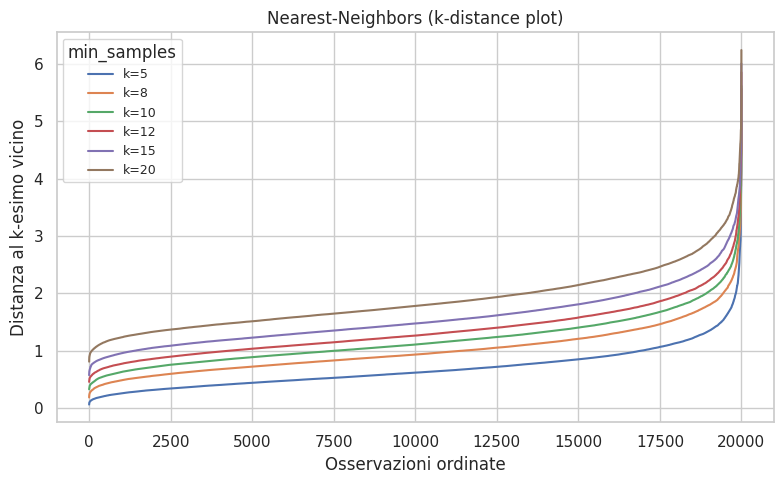


=== TOP 15 soluzioni DBSCAN (vincolate per interpretabilità) ===
 eps  min_samples  n_clusters  noise_%  min_cluster_size  median_cluster_size  max_cluster_size  imbalance_max_med  mean_noise_dist  sil_tsne  sil_pca10     score
 2.8           15          15    0.345               103                579.0              3924           6.777202         2.716897  0.233215  -0.006175  0.302381
 2.7           15          16    0.410               103                549.5              3924           7.141037         2.595695  0.230429  -0.009372  0.132844
 3.1           15          10    0.200               103               1171.5              7566           6.458387         2.634922  0.056104  -0.032654  0.043808
 3.0           15          10    0.250               103               1170.0              7563           6.464103         2.448237  0.056226  -0.032545 -0.013409
 2.8           12          10    0.325               103               1170.0              8396           7.176068     

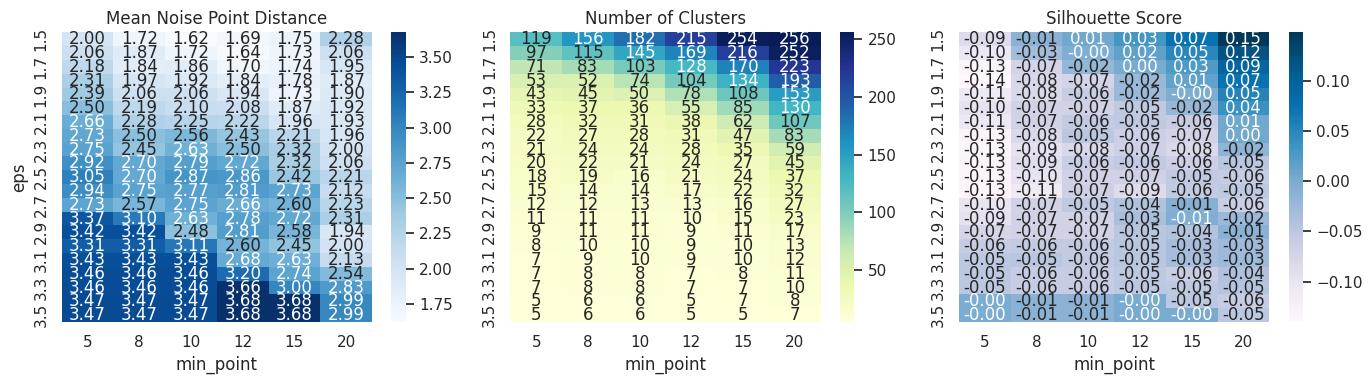


=== CONFIGURAZIONE FINALE (compromesso interpretabilità + qualità) ===
eps                       2.800000
min_samples              15.000000
n_clusters               15.000000
noise_%                   0.345000
min_cluster_size        103.000000
median_cluster_size     579.000000
max_cluster_size       3924.000000
imbalance_max_med         6.777202
sil_tsne                  0.233215
sil_pca10                -0.006175
mean_noise_dist           2.716897
sil_pca10_norm            1.000000
noise_norm                0.690476
k_norm                    0.833333
score                     0.302381

DBSCAN finale -> eps=2.8, min_samples=15
Cluster (senza rumore): 15
Rumore: 0.34%
Silhouette t-SNE (qualitativa): 0.233
Silhouette PCA 10D: -0.006


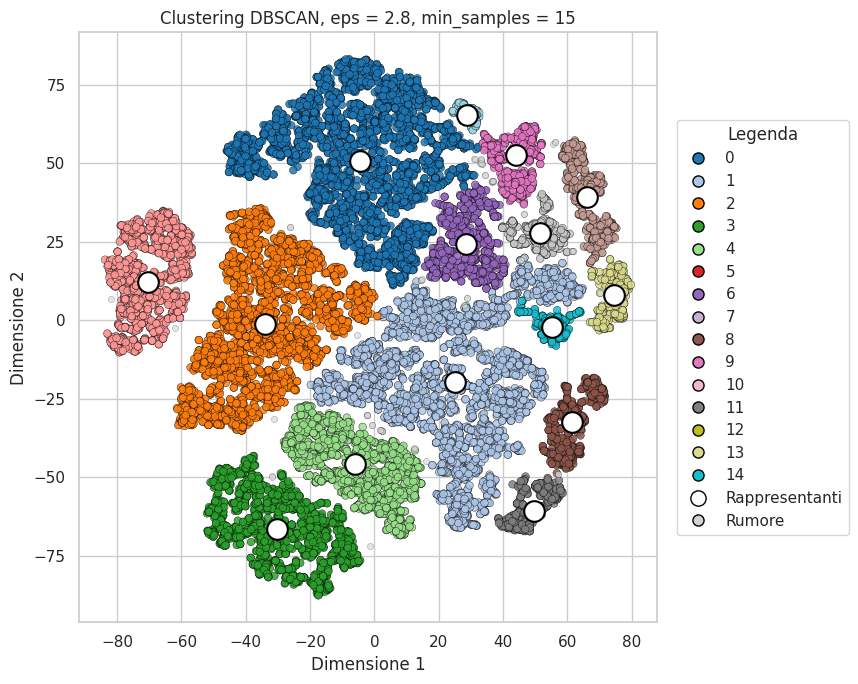

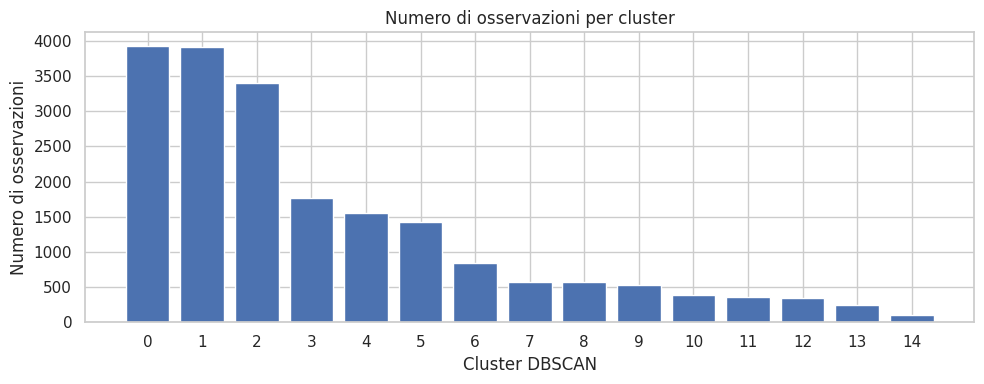


Numero di osservazioni per cluster: 
0     3924
1     3912
2     3394
3     1765
4     1553
5     1423
6      835
7      579
8      571
9      528
10     386
11     362
12     345
13     251
14     103
Name: count, dtype: int64


In [ ]:
# ============================================
# BLOCCO 7 - DBSCAN su t-SNE (tuning "stile PDF": compromesso interpretabilità/qualità)
# + PLOT DIAGNOSTICI "stile PDF" (3 heatmap in 1 figura)
# + PLOT FINALE "stile K-MEANS" con legenda ESTERNA (no overlay)
# ============================================
print("=== 7. DBSCAN su t-SNE (tuning + scelta bilanciata) ===")

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 7.1 k-distance plot
# -------------------------------
min_samples_grid = [5, 8, 10, 12, 15, 20]

plt.figure(figsize=(8, 5))
for k in min_samples_grid:
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_tsne)
    dists, _ = nn.kneighbors(X_tsne)
    k_dists = np.sort(dists[:, -1])
    plt.plot(k_dists, label=f"k={k}", linewidth=1.5)

plt.title("Nearest-Neighbors (k-distance plot)")
plt.xlabel("Osservazioni ordinate")
plt.ylabel("Distanza al k-esimo vicino")
plt.legend(title="min_samples", fontsize=9)
plt.tight_layout()
plt.show()

# -------------------------------
# 7.2 Grid search DBSCAN: eps x min_samples
# Valutazione:
# - n_clusters (senza rumore)
# - % rumore
# - silhouette su t-SNE (solo indicativa)
# - silhouette su PCA 10D (preferibile)
# - sbilanciamento cluster (max/median)
# -------------------------------
X_pca_10 = X_pca[idx_tsne, :10]
eps_grid = np.round(np.arange(1.5, 3.6, 0.1), 2)

results = []
for ms in min_samples_grid:
    for eps in eps_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_tsne)

        mask = labels != -1
        uniq = np.unique(labels[mask])
        n_clusters = len(uniq)
        noise_pct = (labels == -1).mean() * 100

        # dimensioni cluster
        if n_clusters > 0:
            sizes = pd.Series(labels[mask]).value_counts()
            min_size = int(sizes.min())
            med_size = float(sizes.median())
            max_size = int(sizes.max())
            imbalance = max_size / med_size if med_size > 0 else np.inf
        else:
            min_size, med_size, max_size, imbalance = 0, 0.0, 0, np.inf

        # silhouette
        if n_clusters >= 2 and mask.sum() > n_clusters:
            sil_tsne = silhouette_score(X_tsne[mask], labels[mask])
            sil_pca  = silhouette_score(X_pca_10[mask], labels[mask])
        else:
            sil_tsne = np.nan
            sil_pca  = np.nan

        # mean noise point distance (distanza media dei punti di rumore dal punto "non rumore" più vicino)
        if np.any(labels == -1) and np.any(labels != -1):
            X_core = X_tsne[labels != -1]
            X_noise = X_tsne[labels == -1]
            nn_core = NearestNeighbors(n_neighbors=1)
            nn_core.fit(X_core)
            d_noise, _ = nn_core.kneighbors(X_noise)
            mean_noise_dist = float(d_noise.mean())
        elif np.any(labels == -1) and not np.any(labels != -1):
            mean_noise_dist = np.nan  # tutto rumore
        else:
            mean_noise_dist = 0.0     # nessun rumore

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_%": noise_pct,
            "min_cluster_size": min_size,
            "median_cluster_size": med_size,
            "max_cluster_size": max_size,
            "imbalance_max_med": imbalance,
            "sil_tsne": sil_tsne,
            "sil_pca10": sil_pca,
            "mean_noise_dist": mean_noise_dist
        })

res_df = pd.DataFrame(results)

# -------------------------------
# 7.3 FILTRI
# -------------------------------
CL_MIN, CL_MAX = 5, 20
NOISE_MAX = 10
IMBAL_MAX = 8
MIN_SIZE_MIN = 100

cand = res_df[
    (res_df["n_clusters"] >= CL_MIN) &
    (res_df["n_clusters"] <= CL_MAX) &
    (res_df["noise_%"] <= NOISE_MAX) &
    (res_df["imbalance_max_med"] <= IMBAL_MAX) &
    (res_df["min_cluster_size"] >= MIN_SIZE_MIN) &
    (~res_df["sil_pca10"].isna())
].copy()

# ---- Scelta "bilanciata": multi-obiettivo (silhouette alta, rumore basso, cluster non troppi)
if len(cand) > 0:
    def _minmax(s):
        if s.max() == s.min():
            return np.zeros_like(s, dtype=float)
        return (s - s.min()) / (s.max() - s.min())

    cand["sil_pca10_norm"] = _minmax(cand["sil_pca10"])
    cand["noise_norm"]     = _minmax(cand["noise_%"])
    cand["k_norm"]         = _minmax(cand["n_clusters"])

    # pesi
    W_SIL = 0.60
    W_NOI = 0.25
    W_K   = 0.15

    cand["score"] = (
        W_SIL * cand["sil_pca10_norm"]
        - W_NOI * cand["noise_norm"]
        - W_K   * cand["k_norm"]
    )

    cand = cand.sort_values(by=["score", "sil_pca10", "noise_%"],
                            ascending=[False, False, True])

print("\n=== TOP 15 soluzioni DBSCAN (vincolate per interpretabilità) ===")
if len(cand) == 0:
    print("Nessuna soluzione soddisfa i vincoli. Prova a rilassare CL_MAX / NOISE_MAX / IMBAL_MAX / MIN_SIZE_MIN.")
else:
    cols_show = ["eps","min_samples","n_clusters","noise_%","min_cluster_size",
                 "median_cluster_size","max_cluster_size","imbalance_max_med",
                 "mean_noise_dist","sil_tsne","sil_pca10","score"]
    print(cand.head(15)[cols_show].to_string(index=False))

# -------------------------------
# 7.4 PLOT
# -------------------------------
pivot_noise_dist = res_df.pivot(index="eps", columns="min_samples", values="mean_noise_dist")
pivot_nclust     = res_df.pivot(index="eps", columns="min_samples", values="n_clusters")
pivot_sil        = res_df.pivot(index="eps", columns="min_samples", values="sil_pca10")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.heatmap(
    pivot_noise_dist,
    ax=axes[0],
    cmap="Blues",
    annot=True, fmt=".2f",
    cbar=True
)
axes[0].set_title("Mean Noise Point Distance")
axes[0].set_xlabel("min_point")
axes[0].set_ylabel("eps")

sns.heatmap(
    pivot_nclust,
    ax=axes[1],
    cmap="YlGnBu",
    annot=True, fmt=".0f",
    cbar=True
)
axes[1].set_title("Number of Clusters")
axes[1].set_xlabel("min_point")
axes[1].set_ylabel("")

sns.heatmap(
    pivot_sil,
    ax=axes[2],
    cmap="PuBu",
    annot=True, fmt=".2f",
    cbar=True
)
axes[2].set_title("Silhouette Score")
axes[2].set_xlabel("min_point")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

# -------------------------------
# 7.5 Scelta finale
# -------------------------------
if len(cand) > 0:
    best = cand.iloc[0]
    BEST_EPS = float(best["eps"])
    BEST_MS  = int(best["min_samples"])

    print("\n=== CONFIGURAZIONE FINALE (compromesso interpretabilità + qualità) ===")
    print(best.to_string())

    db_best = DBSCAN(eps=BEST_EPS, min_samples=BEST_MS)
    labels_db = db_best.fit_predict(X_tsne)

    mask = labels_db != -1
    uniq = np.unique(labels_db[mask])
    n_clusters_best = len(uniq)
    noise_pct_best  = (labels_db == -1).mean() * 100

    if n_clusters_best >= 2 and mask.sum() > n_clusters_best:
        sil_best_tsne = silhouette_score(X_tsne[mask], labels_db[mask])
        sil_best_pca  = silhouette_score(X_pca_10[mask], labels_db[mask])
    else:
        sil_best_tsne = np.nan
        sil_best_pca  = np.nan

    print(f"\nDBSCAN finale -> eps={BEST_EPS}, min_samples={BEST_MS}")
    print(f"Cluster (senza rumore): {n_clusters_best}")
    print(f"Rumore: {noise_pct_best:.2f}%")
    print(f"Silhouette t-SNE (qualitativa): {sil_best_tsne:.3f}")
    print(f"Silhouette PCA 10D: {sil_best_pca:.3f}")

    labels_plot = labels_db.copy()
    sizes = pd.Series(labels_db[mask]).value_counts()
    uniq_sorted = sizes.index.to_list()  # desc
    remap = {old: new for new, old in enumerate(uniq_sorted)}
    labels_plot[mask] = np.array([remap[c] for c in labels_db[mask]])

    K = len(uniq_sorted)

    rep_points = []
    for k in range(K):
        idx_k = np.where(labels_plot == k)[0]
        pts = X_tsne[idx_k]
        mu = pts.mean(axis=0)
        d = np.linalg.norm(pts - mu, axis=1)
        rep_points.append(pts[np.argmin(d)])
    rep_points = np.array(rep_points)

    plt.figure(figsize=(11, 7))
    cmap = "tab10" if K <= 10 else "tab20"

    # cluster senza rumore
    plt.scatter(
        X_tsne[mask, 0], X_tsne[mask, 1],
        c=labels_plot[mask],
        cmap=cmap,
        s=30, alpha=0.85,
        edgecolors="black", linewidths=0.3
    )

    # rumore (se presente)
    has_noise = np.any(labels_db == -1)
    if has_noise:
        plt.scatter(
            X_tsne[~mask, 0], X_tsne[~mask, 1],
            c="lightgray",
            s=20, alpha=0.6,
            edgecolors="black", linewidths=0.2
        )

    # rappresentanti
    plt.scatter(
        rep_points[:, 0], rep_points[:, 1],
        c="white", s=220,
        edgecolors="black", linewidths=1.5,
        zorder=5
    )

    plt.title(f"Clustering DBSCAN, eps = {BEST_EPS}, min_samples = {BEST_MS}")
    plt.xlabel("Dimensione 1")
    plt.ylabel("Dimensione 2")

    # ---------- LEGENDA ESTERNA ----------
    legend_elements = []

    for k in range(K):
        legend_elements.append(
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                label=f"{k}",
                markerfacecolor=plt.cm.tab20(k / max(K, 1)) if K > 10 else plt.cm.tab10(k / max(K, 1)),
                markeredgecolor='black',
                markersize=8
            )
        )

    legend_elements.append(
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            label="Rappresentanti",
            markerfacecolor='white',
            markeredgecolor='black',
            markersize=11
        )
    )

    if has_noise:
        legend_elements.append(
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                label="Rumore",
                markerfacecolor='lightgray',
                markeredgecolor='black',
                markersize=8
            )
        )

    plt.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        title="Legenda"
    )

    plt.tight_layout(rect=[0, 0, 0.80, 1])
    plt.show()

    sizes_mapped = pd.Series(labels_plot[mask]).value_counts().sort_index()

    plt.figure(figsize=(10, 4))
    plt.bar(sizes_mapped.index.astype(str), sizes_mapped.values)
    plt.title("Numero di osservazioni per cluster")
    plt.xlabel("Cluster DBSCAN")
    plt.ylabel("Numero di osservazioni")
    plt.tight_layout()
    plt.show()

    print("\nNumero di osservazioni per cluster: ")
    print(sizes_mapped)

=== 8. Profilazione cluster DBSCAN ===

Numero di osservazioni per cluster DBSCAN (senza rumore):
cluster_db
2     3924
1     3912
0     3394
3     1765
5     1553
7     1423
10     835
13     579
14     571
4      528
8      386
12     362
11     345
9      251
6      103
Name: count, dtype: int64


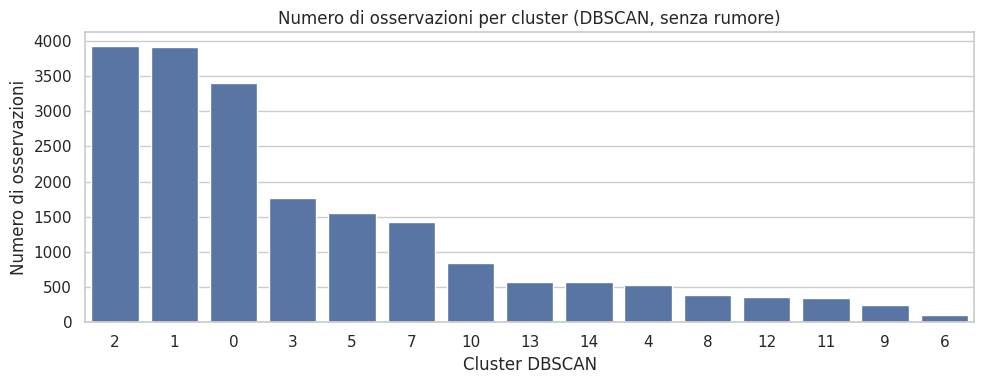

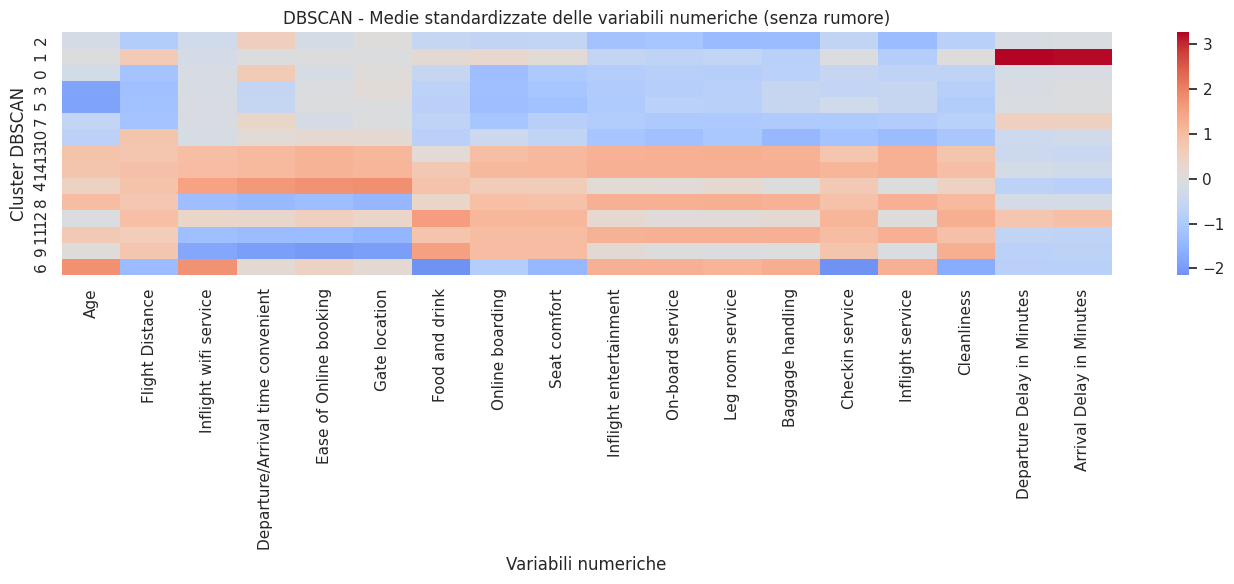


Soddisfazione per cluster DBSCAN (%):
satisfaction  neutral or dissatisfied  satisfied
cluster_db                                      
2                                80.5       19.5
1                                32.4       67.6
0                                80.7       19.3
3                                77.3       22.7
5                                75.1       24.9
7                                75.7       24.3
10                               56.9       43.1
13                                0.7       99.3
14                                1.2       98.8
4                                 5.9       94.1
8                                 0.0      100.0
12                                4.7       95.3
11                                1.2       98.8
9                                 2.4       97.6
6                                12.6       87.4


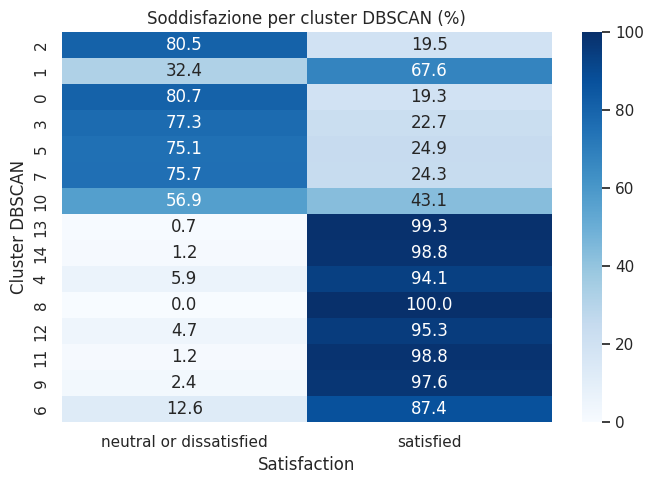

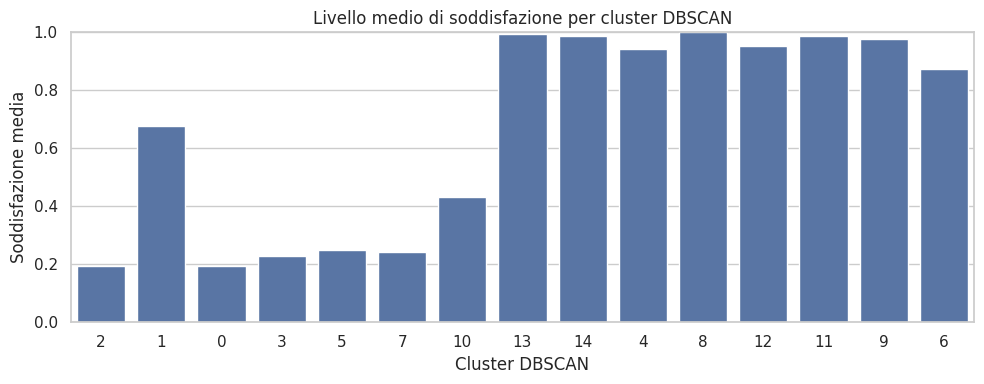


Classe di viaggio per cluster DBSCAN (%):
Class       Business   Eco  Eco Plus
cluster_db                          
2               17.9  82.1       0.0
1               91.6   8.2       0.3
0                4.9  95.1       0.0
3               39.5  60.5       0.0
5               40.2  59.8       0.0
7                0.0   0.0     100.0
10              98.2   1.8       0.0
13              99.8   0.2       0.0
14              99.3   0.7       0.0
4               99.6   0.4       0.0
8               99.7   0.3       0.0
12              99.2   0.8       0.0
11              99.1   0.9       0.0
9               99.2   0.8       0.0
6                1.9  98.1       0.0


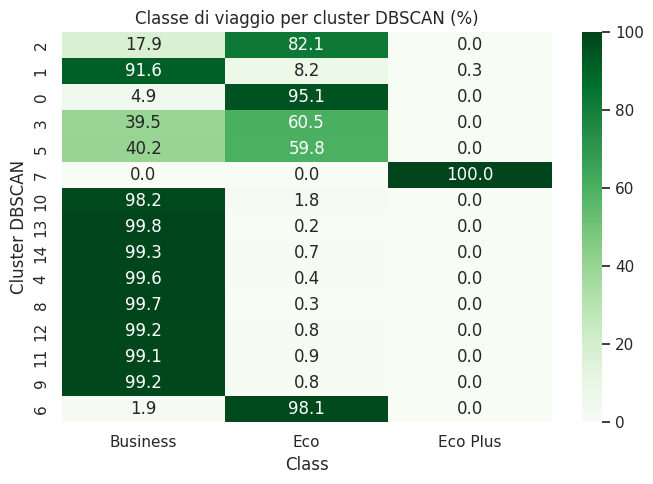

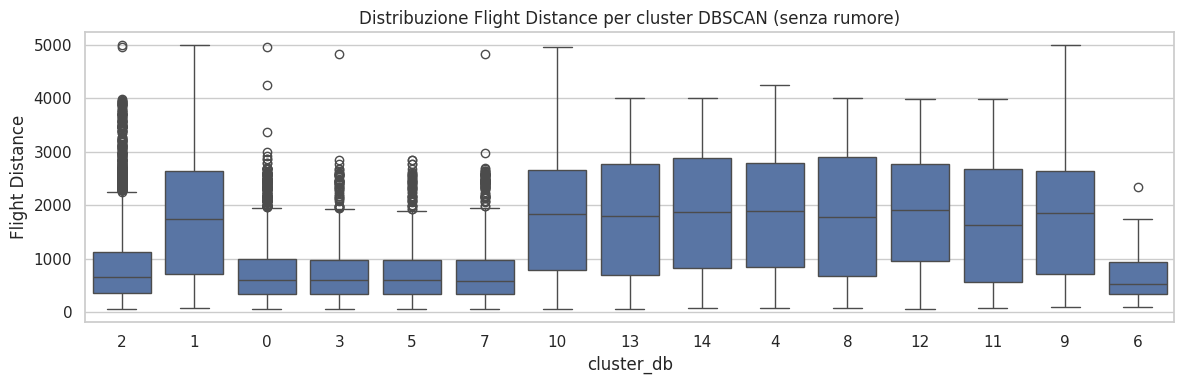

In [ ]:
# ============================================
# BLOCCO 8 - Profilazione cluster DBSCAN
# ============================================
print("=== 8. Profilazione cluster DBSCAN ===")

df_db = df_tsne_encoded.copy()
df_db["cluster_db"] = labels_db

# Escludiamo il rumore (-1) per i profili
df_db_no_noise = df_db[df_db["cluster_db"] != -1].copy()

# numero osservazioni per cluster (senza rumore)
db_counts = df_db_no_noise["cluster_db"].value_counts().sort_values(ascending=False)
print("\nNumero di osservazioni per cluster DBSCAN (senza rumore):")
print(db_counts)

plt.figure(figsize=(10,4))
sns.barplot(x=db_counts.index.astype(str), y=db_counts.values)
plt.title("Numero di osservazioni per cluster (DBSCAN, senza rumore)")
plt.xlabel("Cluster DBSCAN")
plt.ylabel("Numero di osservazioni")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Ordine cluster per leggibilità (dal più grande al più piccolo)
cluster_order = db_counts.index.tolist()

# Usiamo solo le variabili numeriche originali (no dummies)
cluster_means_db = df_db_no_noise.groupby("cluster_db")[num_cols_encoded].mean().loc[cluster_order]
cluster_means_db_std = (cluster_means_db - cluster_means_db.mean()) / cluster_means_db.std()

plt.figure(figsize=(14,6))
sns.heatmap(cluster_means_db_std, cmap="coolwarm", center=0)
plt.title("DBSCAN - Medie standardizzate delle variabili numeriche (senza rumore)")
plt.xlabel("Variabili numeriche")
plt.ylabel("Cluster DBSCAN")
plt.tight_layout()
plt.show()

# Soddisfazione per cluster DBSCAN
if sat_col is not None:
    df_db_sat = df_tsne_raw[[sat_col]].copy()
    df_db_sat["cluster_db"] = labels_db
    df_db_sat_no_noise = df_db_sat[df_db_sat["cluster_db"] != -1].copy()

    sat_ct_db = pd.crosstab(
        df_db_sat_no_noise["cluster_db"],
        df_db_sat_no_noise[sat_col],
        normalize="index"
    ).loc[cluster_order] * 100

    print("\nSoddisfazione per cluster DBSCAN (%):")
    print(sat_ct_db.round(1))

    plt.figure(figsize=(7,5))
    sns.heatmap(sat_ct_db.round(1), annot=True, fmt=".1f", cmap="Blues")
    plt.title("Soddisfazione per cluster DBSCAN (%)")
    plt.ylabel("Cluster DBSCAN")
    plt.xlabel("Satisfaction")
    plt.tight_layout()
    plt.show()

    # 🔹 (facoltativo ma utile) soddisfazione media per cluster
    sat_map = {"neutral or dissatisfied": 0, "satisfied": 1}
    df_db_sat_no_noise["sat_num"] = df_db_sat_no_noise[sat_col].map(sat_map)
    sat_mean_db = df_db_sat_no_noise.groupby("cluster_db")["sat_num"].mean().loc[cluster_order]

    plt.figure(figsize=(10,4))
    sns.barplot(x=sat_mean_db.index.astype(str), y=sat_mean_db.values)
    plt.title("Livello medio di soddisfazione per cluster DBSCAN")
    plt.xlabel("Cluster DBSCAN")
    plt.ylabel("Soddisfazione media")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# Classe di viaggio per cluster DBSCAN
if class_col is not None:
    df_db_class = df_tsne_raw[[class_col]].copy()
    df_db_class["cluster_db"] = labels_db
    df_db_class_no_noise = df_db_class[df_db_class["cluster_db"] != -1]

    class_ct_db = pd.crosstab(
        df_db_class_no_noise["cluster_db"],
        df_db_class_no_noise[class_col],
        normalize="index"
    ).loc[cluster_order] * 100

    print("\nClasse di viaggio per cluster DBSCAN (%):")
    print(class_ct_db.round(1))

    plt.figure(figsize=(7,5))
    sns.heatmap(class_ct_db.round(1), annot=True, fmt=".1f", cmap="Greens")
    plt.title("Classe di viaggio per cluster DBSCAN (%)")
    plt.ylabel("Cluster DBSCAN")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

# Boxplot Flight Distance per cluster DBSCAN
if "Flight Distance" in num_cols:
    df_db_fd = df_tsne_raw[["Flight Distance"]].copy()
    df_db_fd["cluster_db"] = labels_db
    df_db_fd_no_noise = df_db_fd[df_db_fd["cluster_db"] != -1]

    plt.figure(figsize=(12,4))
    sns.boxplot(data=df_db_fd_no_noise, x="cluster_db", y="Flight Distance", order=cluster_order)
    plt.title("Distribuzione Flight Distance per cluster DBSCAN (senza rumore)")
    plt.tight_layout()
    plt.show()

=== 9. UMAP + DBSCAN (tuning + scelta + profilazione) ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (20000, 2)


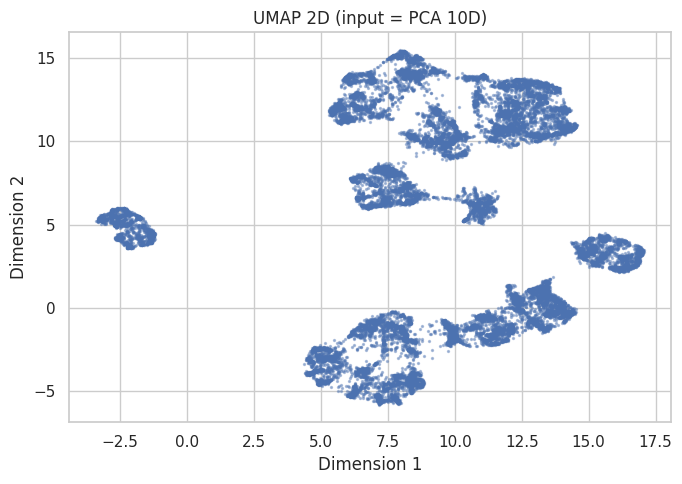

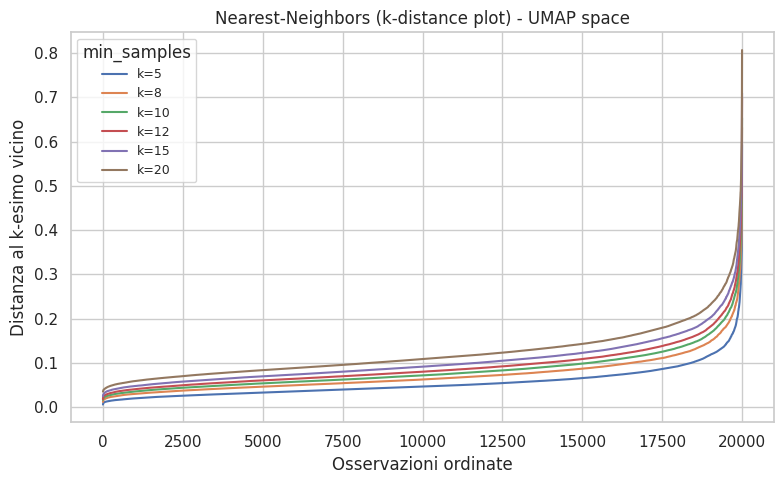


=== TOP 15 soluzioni DBSCAN su UMAP (vincolate per interpretabilità) ===
 eps  min_samples  n_clusters  noise_%  min_cluster_size  median_cluster_size  max_cluster_size  imbalance_max_med  mean_noise_dist  sil_umap  sil_pca10    score
 0.4           20           7    0.075               698               1780.0              7368           4.139326         0.253099  0.514944   0.077691 0.309968
 0.3           15          10    0.210               698               1671.0              3458           2.069420         0.243295  0.544804   0.084535 0.303310
 0.3           12           9    0.160               696               1780.0              3751           2.107303         0.277329  0.580613   0.081822 0.297865
 0.5            5           5    0.000              1429               2478.0              7375           2.976190         0.000000  0.475272   0.069770 0.217866
 0.5            8           5    0.000              1429               2478.0              7375           2.976190  

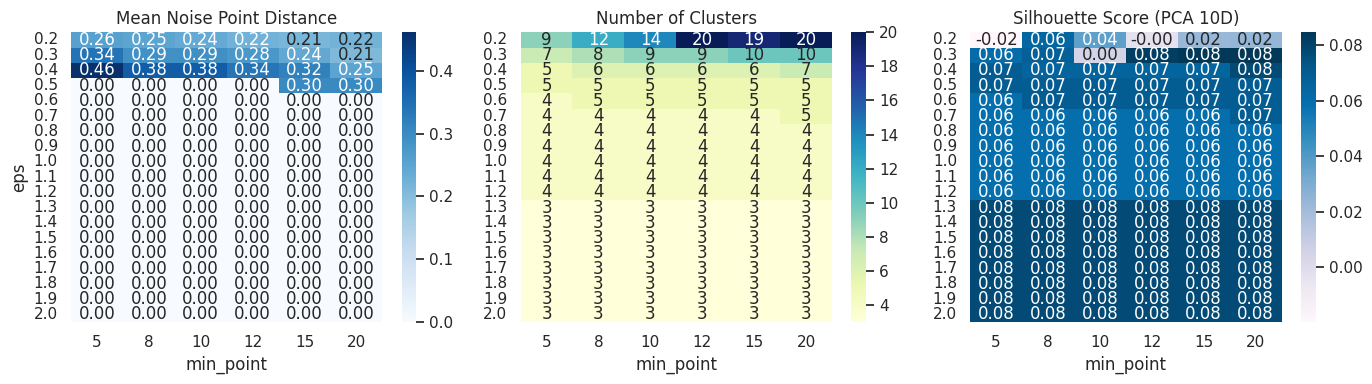


=== CONFIGURAZIONE FINALE (UMAP+DBSCAN) ===
eps                       0.400000
min_samples              20.000000
n_clusters                7.000000
noise_%                   0.075000
min_cluster_size        698.000000
median_cluster_size    1780.000000
max_cluster_size       7368.000000
imbalance_max_med         4.139326
sil_umap                  0.514944
sil_pca10                 0.077691
mean_noise_dist           0.253099
sil_pca10_norm            0.702229
noise_norm                0.205479
k_norm                    0.400000
score                     0.309968

DBSCAN finale (UMAP) -> eps=0.4, min_samples=20
Cluster (senza rumore): 7
Rumore: 0.07%
Silhouette UMAP (indicativa): 0.515
Silhouette PCA 10D: 0.078


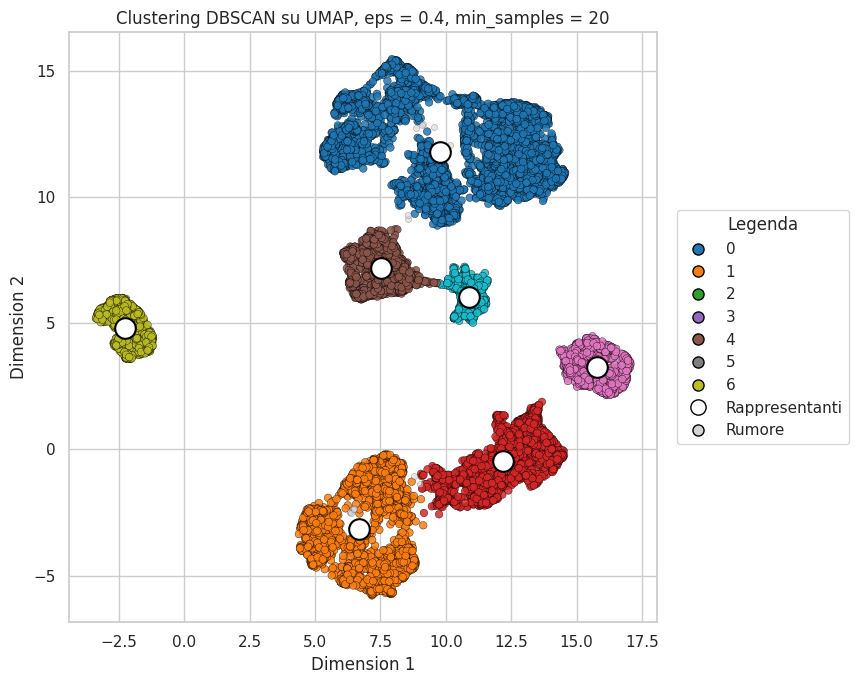

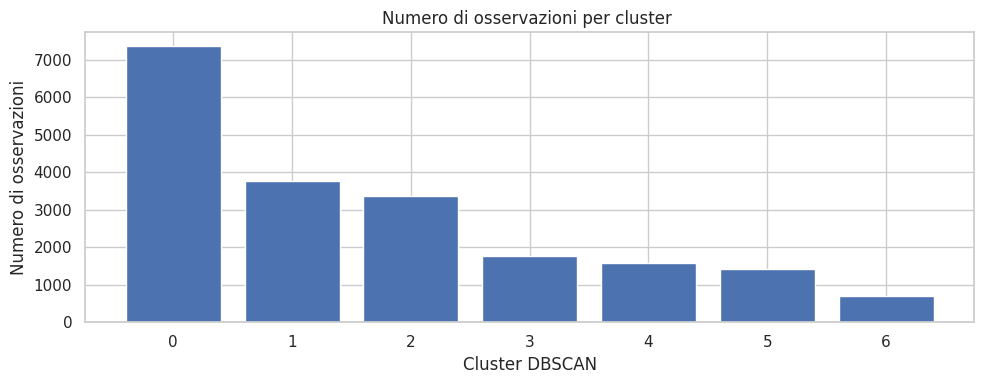


Numero di osservazioni per cluster (UMAP+DBSCAN):
0    7368
1    3759
2    3381
3    1780
4    1570
5    1429
6     698
Name: count, dtype: int64

=== 10. Profilazione cluster UMAP+DBSCAN ===

Numero di osservazioni per cluster (senza rumore):
cluster_db_umap
1    7368
2    3759
0    3381
3    1780
4    1570
5    1429
6     698
Name: count, dtype: int64


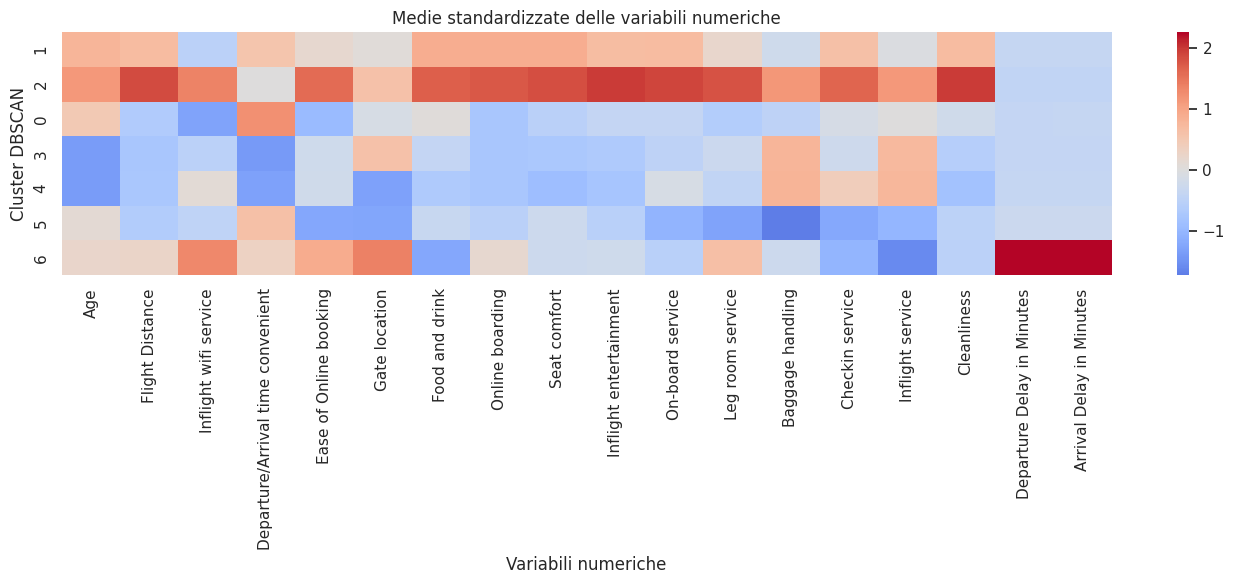


Soddisfazione per cluster (%):
satisfaction     neutral or dissatisfied  satisfied
cluster_db_umap                                    
0                                   80.5       19.5
1                                   50.4       49.6
2                                   21.7       78.3
3                                   76.6       23.4
4                                   75.2       24.8
5                                   75.8       24.2
6                                   68.5       31.5


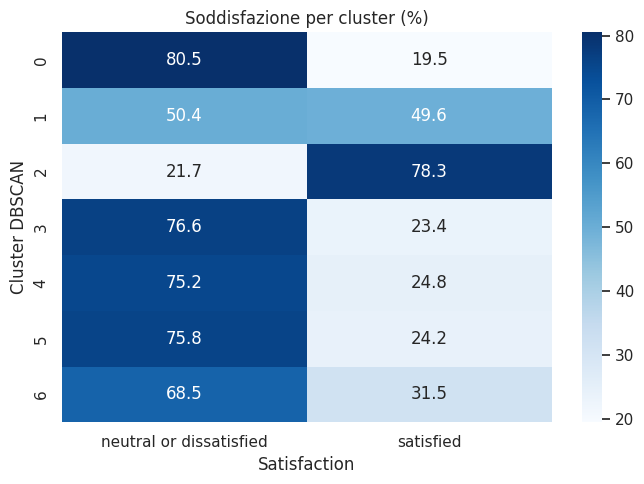

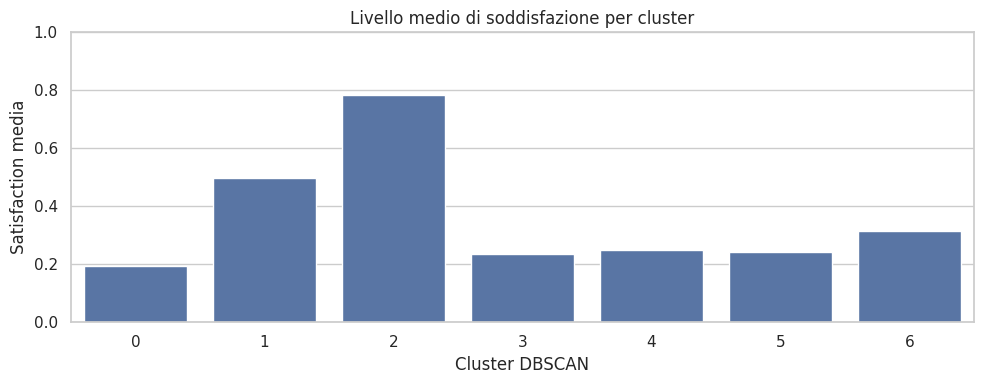


Classe di viaggio per cluster (%):
Class            Business   Eco  Eco Plus
cluster_db_umap                          
0                     4.9  95.1       0.0
1                    54.9  45.1       0.0
2                    99.3   0.7       0.0
3                    40.3  59.7       0.0
4                    40.9  59.1       0.0
5                     0.0   0.0     100.0
6                    48.6  50.4       1.0


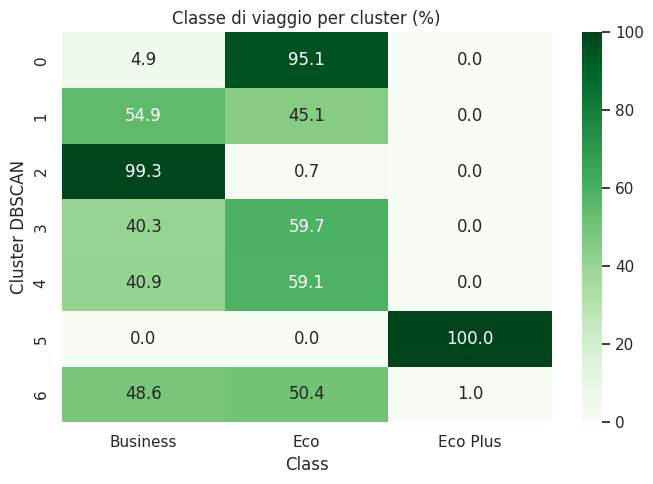

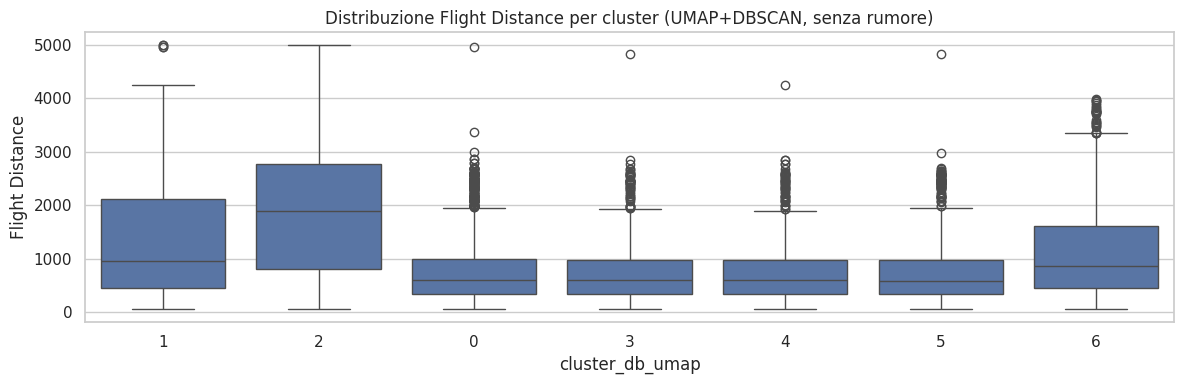

In [ ]:
# ============================================
# BLOCCO 9 - UMAP + DBSCAN
# ============================================

import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("=== 9. UMAP + DBSCAN (tuning + scelta + profilazione) ===")

# -------------------------------------------------
# 0) Subset handling
# -------------------------------------------------
USE_TSNE_SUBSET = True

if USE_TSNE_SUBSET and ("idx_tsne" in globals()) and (idx_tsne is not None):
    idx_umap = idx_tsne
    X_umap_in = X_pca[idx_umap, :10]
    df_umap_raw = df_raw.iloc[idx_umap].copy() if "df_raw" in globals() else None

    if "df_encoded" in globals():
        df_umap_encoded = df_encoded.iloc[idx_umap].copy()
    elif "df_tsne_encoded" in globals():
        df_umap_encoded = df_tsne_encoded.copy()
    else:
        df_umap_encoded = None

else:
    idx_umap = None
    X_umap_in = X_pca[:, :10]
    df_umap_raw = df_raw.copy() if "df_raw" in globals() else None
    df_umap_encoded = df_encoded.copy() if "df_encoded" in globals() else None

# -------------------------------------------------
# 1) UMAP (2D)
# -------------------------------------------------
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.10,
    metric="cosine",
    random_state=RANDOM_STATE if "RANDOM_STATE" in globals() else 42
)

X_umap = umap_model.fit_transform(X_umap_in)
print("UMAP shape:", X_umap.shape)

plt.figure(figsize=(7,5))
plt.scatter(X_umap[:,0], X_umap[:,1], s=2, alpha=0.4)
plt.title("UMAP 2D (input = PCA 10D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 2) k-distance plot
# -------------------------------------------------
min_samples_grid = [5, 8, 10, 12, 15, 20]

plt.figure(figsize=(8, 5))
for k in min_samples_grid:
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_umap)
    dists, _ = nn.kneighbors(X_umap)
    k_dists = np.sort(dists[:, -1])
    plt.plot(k_dists, label=f"k={k}", linewidth=1.5)

plt.title("Nearest-Neighbors (k-distance plot) - UMAP space")
plt.xlabel("Osservazioni ordinate")
plt.ylabel("Distanza al k-esimo vicino")
plt.legend(title="min_samples", fontsize=9)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3) Tuning DBSCAN su UMAP: eps x min_samples
#    - silhouette su PCA 10D (preferibile per confronto) + silhouette su UMAP (indicativa)
#    - mean noise point distance
# -------------------------------------------------
X_pca_10_umap = X_umap_in  # già PCA 10D coerente con UMAP input

eps_grid = np.round(np.arange(0.2, 2.05, 0.1), 2)

results = []
for ms in min_samples_grid:
    for eps in eps_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_umap)

        mask = labels != -1
        uniq = np.unique(labels[mask])
        n_clusters = len(uniq)
        noise_pct = (labels == -1).mean() * 100

        # dimensioni cluster
        if n_clusters > 0:
            sizes = pd.Series(labels[mask]).value_counts()
            min_size = int(sizes.min())
            med_size = float(sizes.median())
            max_size = int(sizes.max())
            imbalance = max_size / med_size if med_size > 0 else np.inf
        else:
            min_size, med_size, max_size, imbalance = 0, 0.0, 0, np.inf

        if n_clusters >= 2 and mask.sum() > n_clusters:
            sil_umap = silhouette_score(X_umap[mask], labels[mask])
            sil_pca  = silhouette_score(X_pca_10_umap[mask], labels[mask])
        else:
            sil_umap = np.nan
            sil_pca  = np.nan

        if np.any(labels == -1) and np.any(labels != -1):
            X_core = X_umap[labels != -1]
            X_noise = X_umap[labels == -1]
            nn_core = NearestNeighbors(n_neighbors=1)
            nn_core.fit(X_core)
            d_noise, _ = nn_core.kneighbors(X_noise)
            mean_noise_dist = float(d_noise.mean())
        elif np.any(labels == -1) and not np.any(labels != -1):
            mean_noise_dist = np.nan
        else:
            mean_noise_dist = 0.0

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_%": noise_pct,
            "min_cluster_size": min_size,
            "median_cluster_size": med_size,
            "max_cluster_size": max_size,
            "imbalance_max_med": imbalance,
            "sil_umap": sil_umap,
            "sil_pca10": sil_pca,
            "mean_noise_dist": mean_noise_dist
        })

res_df = pd.DataFrame(results)

# -------------------------------------------------
# 4) Filtri + scoring multi-obiettivo
# -------------------------------------------------
CL_MIN, CL_MAX = 5, 20
NOISE_MAX = 10
IMBAL_MAX = 8
MIN_SIZE_MIN = 100

cand = res_df[
    (res_df["n_clusters"] >= CL_MIN) &
    (res_df["n_clusters"] <= CL_MAX) &
    (res_df["noise_%"] <= NOISE_MAX) &
    (res_df["imbalance_max_med"] <= IMBAL_MAX) &
    (res_df["min_cluster_size"] >= MIN_SIZE_MIN) &
    (~res_df["sil_pca10"].isna())
].copy()

if len(cand) > 0:
    def _minmax(s):
        if s.max() == s.min():
            return np.zeros_like(s, dtype=float)
        return (s - s.min()) / (s.max() - s.min())

    cand["sil_pca10_norm"] = _minmax(cand["sil_pca10"])
    cand["noise_norm"]     = _minmax(cand["noise_%"])
    cand["k_norm"]         = _minmax(cand["n_clusters"])

    W_SIL = 0.60
    W_NOI = 0.25
    W_K   = 0.15

    cand["score"] = (
        W_SIL * cand["sil_pca10_norm"]
        - W_NOI * cand["noise_norm"]
        - W_K   * cand["k_norm"]
    )

    cand = cand.sort_values(by=["score", "sil_pca10", "noise_%"],
                            ascending=[False, False, True])

print("\n=== TOP 15 soluzioni DBSCAN su UMAP (vincolate per interpretabilità) ===")
if len(cand) == 0:
    print("Nessuna soluzione soddisfa i vincoli. Prova a rilassare CL_MAX / NOISE_MAX / IMBAL_MAX / MIN_SIZE_MIN o ad allargare eps_grid.")
else:
    cols_show = [
        "eps","min_samples","n_clusters","noise_%","min_cluster_size",
        "median_cluster_size","max_cluster_size","imbalance_max_med",
        "mean_noise_dist","sil_umap","sil_pca10","score"
    ]
    print(cand.head(15)[cols_show].to_string(index=False))

# -------------------------------------------------
# 5) Plot diagnostici
# -------------------------------------------------
pivot_noise_dist = res_df.pivot(index="eps", columns="min_samples", values="mean_noise_dist")
pivot_nclust     = res_df.pivot(index="eps", columns="min_samples", values="n_clusters")
pivot_sil        = res_df.pivot(index="eps", columns="min_samples", values="sil_pca10")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.heatmap(pivot_noise_dist, ax=axes[0], cmap="Blues", annot=True, fmt=".2f", cbar=True)
axes[0].set_title("Mean Noise Point Distance")
axes[0].set_xlabel("min_point")
axes[0].set_ylabel("eps")

sns.heatmap(pivot_nclust, ax=axes[1], cmap="YlGnBu", annot=True, fmt=".0f", cbar=True)
axes[1].set_title("Number of Clusters")
axes[1].set_xlabel("min_point")
axes[1].set_ylabel("")

sns.heatmap(pivot_sil, ax=axes[2], cmap="PuBu", annot=True, fmt=".2f", cbar=True)
axes[2].set_title("Silhouette Score (PCA 10D)")
axes[2].set_xlabel("min_point")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 6) Fit finale
# -------------------------------------------------
if len(cand) > 0:
    best = cand.iloc[0]
    BEST_EPS = float(best["eps"])
    BEST_MS  = int(best["min_samples"])

    print("\n=== CONFIGURAZIONE FINALE (UMAP+DBSCAN) ===")
    print(best.to_string())

    db_best = DBSCAN(eps=BEST_EPS, min_samples=BEST_MS)
    labels_db_umap = db_best.fit_predict(X_umap)

    mask = labels_db_umap != -1
    uniq = np.unique(labels_db_umap[mask])
    n_clusters_best = len(uniq)
    noise_pct_best  = (labels_db_umap == -1).mean() * 100

    if n_clusters_best >= 2 and mask.sum() > n_clusters_best:
        sil_best_umap = silhouette_score(X_umap[mask], labels_db_umap[mask])
        sil_best_pca  = silhouette_score(X_pca_10_umap[mask], labels_db_umap[mask])
    else:
        sil_best_umap = np.nan
        sil_best_pca  = np.nan

    print(f"\nDBSCAN finale (UMAP) -> eps={BEST_EPS}, min_samples={BEST_MS}")
    print(f"Cluster (senza rumore): {n_clusters_best}")
    print(f"Rumore: {noise_pct_best:.2f}%")
    print(f"Silhouette UMAP (indicativa): {sil_best_umap:.3f}")
    print(f"Silhouette PCA 10D: {sil_best_pca:.3f}")

    # rimappa cluster per dimensione (0 = più grande)
    labels_plot = labels_db_umap.copy()
    sizes = pd.Series(labels_db_umap[mask]).value_counts()
    uniq_sorted = sizes.index.to_list()  # desc
    remap = {old: new for new, old in enumerate(uniq_sorted)}
    labels_plot[mask] = np.array([remap[c] for c in labels_db_umap[mask]])
    K = len(uniq_sorted)

    # punti rappresentativi (closest-to-mean)
    rep_points = []
    for k in range(K):
        idx_k = np.where(labels_plot == k)[0]
        pts = X_umap[idx_k]
        mu = pts.mean(axis=0)
        d = np.linalg.norm(pts - mu, axis=1)
        rep_points.append(pts[np.argmin(d)])
    rep_points = np.array(rep_points)

    # plot stile K-Means + legenda esterna
    plt.figure(figsize=(11, 7))
    cmap = "tab10" if K <= 10 else "tab20"

    plt.scatter(
        X_umap[mask, 0], X_umap[mask, 1],
        c=labels_plot[mask],
        cmap=cmap,
        s=30, alpha=0.85,
        edgecolors="black", linewidths=0.3
    )

    has_noise = np.any(labels_db_umap == -1)
    if has_noise:
        plt.scatter(
            X_umap[~mask, 0], X_umap[~mask, 1],
            c="lightgray",
            s=20, alpha=0.6,
            edgecolors="black", linewidths=0.2
        )

    plt.scatter(
        rep_points[:, 0], rep_points[:, 1],
        c="white", s=220,
        edgecolors="black", linewidths=1.5,
        zorder=5
    )

    plt.title(f"Clustering DBSCAN su UMAP, eps = {BEST_EPS}, min_samples = {BEST_MS}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    legend_elements = []
    for k in range(K):
        legend_elements.append(
            plt.Line2D(
                [0], [0], marker='o', color='w', label=f"{k}",
                markerfacecolor=plt.cm.tab20(k / max(K, 1)) if K > 10 else plt.cm.tab10(k / max(K, 1)),
                markeredgecolor='black', markersize=8
            )
        )

    legend_elements.append(
        plt.Line2D(
            [0], [0], marker='o', color='w', label="Rappresentanti",
            markerfacecolor='white', markeredgecolor='black', markersize=11
        )
    )

    if has_noise:
        legend_elements.append(
            plt.Line2D(
                [0], [0], marker='o', color='w', label="Rumore",
                markerfacecolor='lightgray', markeredgecolor='black', markersize=8
            )
        )

    plt.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        title="Legenda"
    )

    plt.tight_layout(rect=[0, 0, 0.80, 1])
    plt.show()

    # numerosità cluster
    sizes_mapped = pd.Series(labels_plot[mask]).value_counts().sort_index()
    plt.figure(figsize=(10, 4))
    plt.bar(sizes_mapped.index.astype(str), sizes_mapped.values)
    plt.title("Numero di osservazioni per cluster ")
    plt.xlabel("Cluster DBSCAN")
    plt.ylabel("Numero di osservazioni")
    plt.tight_layout()
    plt.show()

    print("\nNumero di osservazioni per cluster (UMAP+DBSCAN):")
    print(sizes_mapped)

    # -------------------------------------------------
    # 7) Profilazione
    # -------------------------------------------------
    print("\n=== 10. Profilazione cluster UMAP+DBSCAN ===")

    if df_umap_raw is not None:
        df_umap_raw = df_umap_raw.copy()
        df_umap_raw["cluster_db_umap"] = labels_db_umap

    if df_umap_encoded is not None:
        df_umap_encoded = df_umap_encoded.copy()
        df_umap_encoded["cluster_db_umap"] = labels_db_umap

    # Escludiamo il rumore
    if df_umap_raw is not None:
        df_umap_raw_nn = df_umap_raw[df_umap_raw["cluster_db_umap"] != -1].copy()
        counts = df_umap_raw_nn["cluster_db_umap"].value_counts().sort_values(ascending=False)
        print("\nNumero di osservazioni per cluster (senza rumore):")
        print(counts)

    # Heatmap medie standardizzate variabili numeriche:
    if (df_umap_encoded is not None) and ("num_cols_encoded" in globals()):
        df_nn = df_umap_encoded[df_umap_encoded["cluster_db_umap"] != -1].copy()
        cluster_order = df_nn["cluster_db_umap"].value_counts().index.tolist()

        cluster_means = df_nn.groupby("cluster_db_umap")[num_cols_encoded].mean().loc[cluster_order]
        cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()

        plt.figure(figsize=(14,6))
        sns.heatmap(cluster_means_std, cmap="coolwarm", center=0)
        plt.title("Medie standardizzate delle variabili numeriche")
        plt.xlabel("Variabili numeriche")
        plt.ylabel("Cluster DBSCAN")
        plt.tight_layout()
        plt.show()

    elif (df_umap_raw is not None) and ("num_cols" in globals()):
        df_nn = df_umap_raw[df_umap_raw["cluster_db_umap"] != -1].copy()
        cluster_order = df_nn["cluster_db_umap"].value_counts().index.tolist()

        cluster_means = df_nn.groupby("cluster_db_umap")[num_cols].mean().loc[cluster_order]
        cluster_means_std = (cluster_means - cluster_means.mean()) / cluster_means.std()

        plt.figure(figsize=(14,6))
        sns.heatmap(cluster_means_std, cmap="coolwarm", center=0)
        plt.title("Medie standardizzate delle variabili numeriche")
        plt.xlabel("Variabili numeriche")
        plt.ylabel("Cluster DBSCAN")
        plt.tight_layout()
        plt.show()

    # Soddisfazione
    if (df_umap_raw is not None) and ("sat_col" in globals()) and (sat_col is not None) and (sat_col in df_umap_raw.columns):
        df_sat = df_umap_raw[[sat_col, "cluster_db_umap"]].copy()
        df_sat = df_sat[df_sat["cluster_db_umap"] != -1].copy()

        sat_ct = pd.crosstab(df_sat["cluster_db_umap"], df_sat[sat_col], normalize="index") * 100
        print("\nSoddisfazione per cluster (%):")
        print(sat_ct.round(1))

        plt.figure(figsize=(7,5))
        sns.heatmap(sat_ct.round(1), annot=True, fmt=".1f", cmap="Blues")
        plt.title("Soddisfazione per cluster (%)")
        plt.ylabel("Cluster DBSCAN")
        plt.xlabel("Satisfaction")
        plt.tight_layout()
        plt.show()

        # soddisfazione media
        sat_map = {"neutral or dissatisfied": 0, "satisfied": 1}
        df_sat["sat_num"] = df_sat[sat_col].map(sat_map)
        sat_mean = df_sat.groupby("cluster_db_umap")["sat_num"].mean()
        sat_mean = sat_mean.loc[sat_mean.index.intersection(cluster_order)] if "cluster_order" in locals() else sat_mean

        plt.figure(figsize=(10,4))
        sns.barplot(x=sat_mean.index.astype(str), y=sat_mean.values)
        plt.title("Livello medio di soddisfazione per cluster")
        plt.xlabel("Cluster DBSCAN")
        plt.ylabel("Satisfaction media")
        plt.ylim(0,1)
        plt.tight_layout()
        plt.show()

    # Classe di viaggio
    if (df_umap_raw is not None) and ("class_col" in globals()) and (class_col is not None) and (class_col in df_umap_raw.columns):
        df_class = df_umap_raw[[class_col, "cluster_db_umap"]].copy()
        df_class = df_class[df_class["cluster_db_umap"] != -1].copy()

        class_ct = pd.crosstab(df_class["cluster_db_umap"], df_class[class_col], normalize="index") * 100
        print("\nClasse di viaggio per cluster (%):")
        print(class_ct.round(1))

        plt.figure(figsize=(7,5))
        sns.heatmap(class_ct.round(1), annot=True, fmt=".1f", cmap="Greens")
        plt.title("Classe di viaggio per cluster (%)")
        plt.ylabel("Cluster DBSCAN")
        plt.xlabel("Class")
        plt.tight_layout()
        plt.show()

    # Flight Distance boxplot
    if (df_umap_raw is not None) and ("Flight Distance" in df_umap_raw.columns):
        df_fd = df_umap_raw[["Flight Distance", "cluster_db_umap"]].copy()
        df_fd = df_fd[df_fd["cluster_db_umap"] != -1].copy()

        order_fd = df_fd["cluster_db_umap"].value_counts().index.tolist()
        plt.figure(figsize=(12,4))
        sns.boxplot(data=df_fd, x="cluster_db_umap", y="Flight Distance", order=order_fd)
        plt.title("Distribuzione Flight Distance per cluster (UMAP+DBSCAN, senza rumore)")
        plt.tight_layout()
        plt.show()
else:
    print("\nNessuna configurazione finale selezionata: cand è vuoto.")